










































































 # **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline
imageList=os.listdir("test_images/")

In [7]:
# A function to open the image files in the "test_images" directory
def read_Images(imageFile):
    #reading in an image
    image = cv2.imread('./test_images/'+imageFile)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    return image

    

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=(255, 0, 0), thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #Initializing different arrays for storing particular x,y coordinates of lines
    lines_positive_slopesPoints=[]# Intializing array to store x,y points for positive slope lines
    lines_negative_slopesPoints=[]# Intializing array to store x,y points for negative slope lines
    lines_positive_intercepts=[]# Intializing array to store y intercept for positive slope lines
    lines_negative_intercepts=[]# Intializing array to store y intercept for negative slope lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2!=x1:
                slope= (y2-y1)/(x2-x1)
                if not math.isnan(slope):
                    if slope > 0.5:
                        lines_positive_slopesPoints.append([x1,y1])#adding x,y points for positive slope lines
                        lines_positive_slopesPoints.append([x2,y2])#adding x,y points for positive slope lines
                        lines_positive_intercepts.append([slope,y1-(slope*x1)])#adding y intercept for positive slope lines
                    elif slope < -0.5:
                        lines_negative_slopesPoints.append([x1,y1])#adding x,y points for negative slope lines
                        lines_negative_slopesPoints.append([x2,y2])#adding x,y points for negative slope lines
                        lines_negative_intercepts.append([slope,y1-(slope*x1)])#adding y intercept for negative slope lines
    # If either array is empty
    if not lines_positive_slopesPoints:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y2-y1)/(x2-x1)
                if slope > 0:
                    lines_positive_slopesPoints.append([x1,y1])
                    lines_positive_slopesPoints.append([x2,y2])
                    lines_positive_intercepts.append([slope,y1-(slope*x1)])
    if not lines_negative_slopesPoints:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y2-y1)/(x2-x1)
                if slope < 0:
                    lines_negative_slopesPoints.append([x1,y1])
                    lines_negative_slopesPoints.append([x2,y2])
                    lines_negative_intercepts.append([slope,y1-(slope*x1)])
    if not lines_positive_slopesPoints:
        print("lines_positive_slopesPoints still empty")
    if not lines_negative_slopesPoints:
        print("lines_negative_slopesPoints still empty")
    # this custom function "avg_slopes_and_intercepts" returns the slope and the intercept
    pos_m,pos_c =avg_slopes_and_intercepts(lines_positive_intercepts)
    neg_m,neg_c =avg_slopes_and_intercepts(lines_negative_intercepts)
    #find intersection of lines
    xPos_intersect=find_intersection_xVal(pos_m,pos_c,neg_m,neg_c)
    xNeg_intersect=find_intersection_xVal(pos_m,pos_c,neg_m,neg_c)
    draw_fitted_lines(img,pos_m,pos_c,xPos_intersect,color,thickness)
    draw_fitted_lines(img,neg_m,neg_c,xNeg_intersect,color,thickness)
    
    
def draw_fitted_lines(img,m,c,intersect_x, color, thickness):
    """
    This function takes in the parameter values as,
    img - The image on which the line are to be drawn
    m- The slope of the line
    c- The y-intercept of the line
    intersect_x - The return value of the function "find_intersection_xVal" which is the intersection point of the positive and negative lines
    thickness - The thickness of the line to be drawn
    """
    #Draw a line 
    x_vanishing=0
    y_vanishing=0
    if m>0:
        x_vanishing=int(intersect_x +100)
        y_vanishing= int(m*x_vanishing+c)
    elif m<0:
        x_vanishing=int(intersect_x -100)
        y_vanishing =int(m*x_vanishing+c)
    point1=(x_vanishing,y_vanishing)

    if m!=0:
        point2 = (int((img.shape[0]-c)/m), int(img.shape[0]))
    cv2.line(img,point1,point2,color,thickness)
    
def find_intersection_xVal(m1,c1,m2,c2):
    """to find the intersection of two lines given their slope and intercept"""
    intersection_point_x = (c2-c1)/(m1-m2)
    return intersection_point_x

def avg_slopes_and_intercepts(lines_intercept):
    """
    The input to this function is the array of ijntercept values of lines.
    This function returns the mean values of the slopes and intercepts .
    """
    # finding the slopes which are at 0.5 standard deviation from the mean
    considered_slopes=[]
    considered_intercepts=[]
    allSlopeValues= [slopeInterceptPair[0] for slopeInterceptPair in lines_intercept]
    mean_slope=np.mean(allSlopeValues)
    std_slope=np.std(allSlopeValues)
    
    for slope in lines_intercept:
        if std_slope!=0.0:
            if slope[0] - mean_slope < 0.1* std_slope:
                considered_slopes.append(slope[0])
                considered_intercepts.append(slope[1])
        elif std_slope==0.0:
            considered_slopes.append(slope[0])
            considered_intercepts.append(slope[1])               
    
    AvgSlope=np.mean(considered_slopes)
    AvgIntercept=np.mean(considered_intercepts)
    
    return AvgSlope,AvgIntercept

      
def hough_lines(img, rho = 2, theta =np.pi/180, threshold=45, min_line_len=40, max_line_gap=80):
    """
    img should be the output of a Canny transform.
    rho = distance resolution in pixels of the Hough grid
    theta = angular resolution in radians of the Hough grid 
    hreshold = minimum number of votes (intersections in Hough grid cell)
    min_line_len = minimum number of pixels making up a line
    max_line_gap =  maximum gap in pixels between connectable line segments
    
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # creating a mask with all pixel values as binary 0 ,with same shape as image
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # call a custom function to draw lines on the mask
    draw_lines(line_img, lines)
    return line_img


def adaptiveGaussThresholding(image):
    threshold= cv2.adaptiveThreshold(image,100,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    return threshold

def binaryThresholding(image):
    ret,threshold = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    return threshold


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

run your solution on all test_images and make copies into the test_images directory).

In [8]:
# TODO: Build your pipeline that will draw lane lines on the test_images
image=read_Images(imageList[3])
def Process(image ,video="default"):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    #converting the image to grayscale
    
    grayscale_Image=grayscale(image)
   
    plt.subplot(3,3,1)
    plt.imshow(grayscale_Image, cmap="gray")
    
    
    #smoothening the image using Gaussian filter
    
    gauss_Image=gaussian_blur(grayscale_Image,5)
    
    plt.subplot(3,3,2)
    plt.imshow(gauss_Image, cmap="gray")
    
    
    #finding the edges in the image using canny edge operator
    
    edges_Line=canny(gauss_Image,100,200)
    
    plt.subplot(3,3,3)
    plt.imshow(edges_Line, cmap="gray")
    
    #defining the  region of interest
    border = 0
    imshape=image.shape
    vertices = np.array([[(0,imshape[0]),(465, 320), (530, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    if video.upper()=="OPTIONAL":
        vertices = np.array([[(150,imshape[0]),(550, 400), (650, 400), (imshape[1],imshape[0])]], dtype=np.int32)  
        
    edges_image_with_mask = region_of_interest(edges_Line, vertices)
   
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2RGB)
    
    plt.subplot(3,3,4)
    plt.imshow(bw_edges_image_with_mask, cmap="gray")
     
    #finding the lane lines in the image
    
    # Hough lines
    lines_image = hough_lines(edges_image_with_mask)
    
    plt.subplot(3,3,5)
    plt.imshow(lines_image)
    
    # Combine lines image with original image
    
    final_image = weighted_img(lines_image, image)
    
    ## Plot final image
    plt.subplot(3,3,6)
    plt.imshow(final_image)

    return final_image



This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


array([[[162, 126,  83],
        [162, 126,  83],
        [162, 126,  83],
        ..., 
        [160, 125,  78],
        [158, 123,  76],
        [157, 122,  74]],

       [[162, 126,  83],
        [162, 126,  83],
        [162, 126,  83],
        ..., 
        [159, 124,  77],
        [158, 122,  75],
        [156, 121,  72]],

       [[161, 126,  82],
        [162, 126,  83],
        [162, 127,  82],
        ..., 
        [159, 124,  75],
        [158, 122,  74],
        [156, 121,  72]],

       ..., 
       [[ 88,  82,  82],
        [ 88,  82,  82],
        [ 88,  82,  82],
        ..., 
        [ 74,  66,  62],
        [ 74,  66,  62],
        [ 74,  66,  62]],

       [[ 87,  81,  82],
        [ 87,  81,  82],
        [ 87,  81,  82],
        ..., 
        [ 73,  66,  62],
        [ 72,  65,  62],
        [ 72,  65,  62]],

       [[ 85,  78,  79],
        [ 85,  78,  79],
        [ 85,  78,  79],
        ..., 
        [ 72,  65,  62],
        [ 72,  65,  62],
        [ 72,  65,

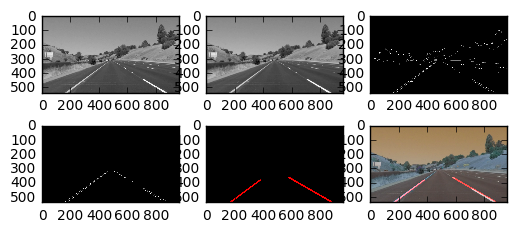

In [9]:
Process(image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(Process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

mean_slope 0.601153046568
std_slope 0.0192769536865
considered_slopes [0.60055096418732778, 0.59322033898305082, 0.59322033898305082, 0.5714285714285714, 0.57499999999999996]
considered_intercepts [15.52066115702479, 21.813559322033939, 24.576271186440692, 39.714285714285722, 38.200000000000045]
frame_mean_slope [0.62689164648910412, 0.58668404271640018]
frame_mean_intercept [24.47369350282484, 27.964955475957037]
slope-m [0.58668404271640018]
mean_slope -0.707402402293
std_slope 0.0252256762319
considered_slopes [-0.75308641975308643]
considered_intercepts [666.87654320987656]
frame_mean_slope [-0.64280022376804113, -0.75308641975308643]
frame_mean_intercept [848.61563834648859, 666.87654320987656]
slope-m [-0.75308641975308643]
m 0.586684042716
type of img.shape-c <class 'numpy.float64'>
m -0.753086419753
type of img.shape-c <class 'numpy.float64'>
lines_image.shape (540, 960, 3)
lines_image [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [

  0%|                                                  | 0/222 [00:00<?, ?it/s]

mean_slope 0.601153046568
std_slope 0.0192769536865
considered_slopes [0.60055096418732778, 0.59322033898305082, 0.59322033898305082, 0.5714285714285714, 0.57499999999999996]
considered_intercepts [15.52066115702479, 21.813559322033939, 24.576271186440692, 39.714285714285722, 38.200000000000045]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037]
slope-m [0.58668404271640018]
mean_slope -0.707402402293
std_slope 0.0252256762319
considered_slopes [-0.75308641975308643]
considered_intercepts [666.87654320987656]
frame_mean_slope [-0.64280022376804113, -0.75308641975308643, -0.75308641975308643]
frame_mean_intercept [848.61563834648859, 666.87654320987656, 666.87654320987656]
slope-m [-0.75308641975308643]
m 0.586684042716
type of img.shape-c <class 'numpy.float64'>
m -0.753086419753
type of img.shape-c <class 'numpy.float64'>
lines_image.shape (540, 960, 3)
lines_image [[[0 0 0]


  0%|▏                                         | 1/222 [00:01<05:46,  1.57s/it]

mean_slope 0.605997249931
std_slope 0.0164303192905
considered_slopes [0.60240963855421692, 0.5901639344262295, 0.58333333333333337, 0.58823529411764708]
considered_intercepts [14.578313253012027, 24.639344262295083, 31.666666666666629, 26.941176470588232]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493]
slope-m [0.5910355501078568]
mean_slope -0.733143338143
std_slope 0.0144563736321
considered_slopes [-0.75357142857142856]
considered_intercepts [666.10714285714289]
frame_mean_slope [-0.64280022376804113, -0.75308641975308643, -0.75308641975308643, -0.75357142857142856]
frame_mean_intercept [848.61563834648859, 666.87654320987656, 666.87654320987656, 666.10714285714289]
slope-m [-0.75357142857142856]
m 0.591035550108
type of img.shape-c <class 'numpy.float64'>
m -0.753571428571
type of img.shape-c <class 'numpy.float64'>
lines_image.s

  1%|▍                                         | 2/222 [00:02<05:04,  1.38s/it]

mean_slope 0.616793818243
std_slope 0.0121407017283
considered_slopes [0.60277777777777775, 0.60074626865671643, 0.61290322580645162]
considered_intercepts [14.788888888888891, 15.421641791044749, 16.322580645161281]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974]
slope-m [0.60547575741364856]
mean_slope -0.752089423216
std_slope 0.0390372808285
considered_slopes [-0.75471698113207553, -0.77952755905511806, -0.80606060606060603]
considered_intercepts [666.62264150943406, 672.29921259842513, 676.4484848484849]
frame_mean_slope [-0.64280022376804113, -0.75308641975308643, -0.75308641975308643, -0.75357142857142856, -0.78010171541593321]
frame_mean_intercept [848.61563834648859, 666.87654320987656, 666.87654320987656, 666.10714285714289, 671.79011298544799]
slope-m [-0.78010171541593321]
m 0.60547

  1%|▌                                         | 3/222 [00:03<04:33,  1.25s/it]

mean_slope 0.609399918977
std_slope 0.0114838775309
considered_slopes [0.60167130919220058, 0.6097560975609756, 0.6097560975609756, 0.60215053763440862, 0.59259259259259256, 0.59999999999999998]
considered_intercepts [15.350974930362099, 15.463414634146375, 13.902439024390276, 14.107526881720446, 23.629629629629676, 22.400000000000034]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818]
slope-m [0.60265443909019212]
mean_slope -0.740263339879
std_slope 0.0358715339242
considered_slopes [-0.75438596491228072, -0.8035714285714286, -0.75221238938053092]
considered_intercepts [665.19298245614038, 674.80357142857144, 665.23008849557527]
frame_mean_slope [-0.64280022376804113, -0.75308641975308643, -0.75308641975308643, -0.75357142857142856, -0.78010171541593321, 

  2%|▊                                         | 4/222 [00:04<04:07,  1.13s/it]

mean_slope 0.609904563136
std_slope 0.0102441583384
considered_slopes [0.60224089635854339, 0.60055096418732778, 0.61038961038961037]
considered_intercepts [15.050420168067262, 15.52066115702479, 19.714285714285722]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924]
slope-m [0.60439382364516048]
mean_slope -0.724394655478
std_slope 0.0220958057625
considered_slopes [-0.72340425531914898, -0.75193798449612403]
considered_intercepts [653.25531914893622, 664.35658914728685]
frame_mean_slope [-0.64280022376804113, -0.75308641975308643, -0.75308641975308643, -0.75357142857142856, -0.78010171541593321, -0.77005659428808004, -0.73767111990763645]
frame_mean_intercept [848.61563834648859, 666.87654320987656, 666.876543209876

  2%|▉                                         | 5/222 [00:05<03:44,  1.03s/it]

mean_slope 0.610324175132
std_slope 0.0161059498989
considered_slopes [0.60248447204968947, 0.60236220472440949, 0.59999999999999998, 0.6071428571428571, 0.59523809523809523, 0.60220994475138123]
considered_intercepts [14.838509316770171, 13.397637795275557, 29.200000000000045, 15.214285714285722, 32.595238095238074, 14.077348066298327]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315]
slope-m [0.60157292898440551]
mean_slope -0.709607421564
std_slope 0.010889472846
considered_slopes [-0.72049689440993792]
considered_intercepts [651.94409937888202]
frame_mean_slope [-0.64280022376804113, -0.75308641975308643, -0.75308641975308643, -0.75357142857142856, -0.78010171541593321, -

  3%|█▏                                        | 6/222 [00:05<03:25,  1.05it/s]

mean_slope 0.617276896855
std_slope 0.0106957898204
considered_slopes [0.60055096418732778, 0.61538461538461542]
considered_intercepts [14.920110192837512, 15.53846153846149]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501]
slope-m [0.60796778978597166]
mean_slope -0.710689342801
std_slope 0.0112357908886
considered_slopes [-0.72192513368983957]
considered_intercepts [652.58823529411768]
frame_mean_slope [-0.64280022376804113, -0.75308641975308643, -0.75308641975308643, -0.75357142857142856, -0.78010171541593321, -0.77005659428808004, -0.73767111990763645, -0.72049689440993792, -0.72192513368983957]
frame_mean_intercept [848.615638346

  3%|█▎                                        | 7/222 [00:06<03:10,  1.13it/s]

mean_slope 0.61298546422
std_slope 0.0121626923895
considered_slopes [0.60055096418732778, 0.60110803324099726]
considered_intercepts [14.319559228650178, 14.83379501385042]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299]
slope-m [0.60082949871416247]
mean_slope -0.716843577013
std_slope 0.0158510650688
considered_slopes [-0.72881355932203384, -0.72727272727272729]
considered_intercepts [654.96610169491521, 648.09090909090912]
frame_mean_slope [-0.64280022376804113, -0.75308641975308643, -0.75308641975308643, -0.75357142857142856, -0.78010171541593321, -0.77005659428808004, -0.7376711199076364

  4%|█▌                                        | 8/222 [00:07<02:59,  1.19it/s]

mean_slope 0.611065407168
std_slope 0.00840398294242
considered_slopes [0.60066006600660071, 0.60055096418732778, 0.61038961038961037, 0.61038961038961037]
considered_intercepts [16.231023102310189, 14.920110192837512, 14.649350649350652, 16.675324675324703]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764]
slope-m [0.60549756274328737]
mean_slope -0.706305346036
std_slope 0.0134139034986
considered_slopes [-0.72519083969465647]
considered_intercepts [654.61068702290072]
frame_mean_slope [-0.64280022376804113, -0.75308641975308643, -0.75308641975308643, -

  4%|█▋                                        | 9/222 [00:08<02:49,  1.25it/s]

mean_slope 0.597452697452
std_slope 0.0250763163183
considered_slopes [0.56043956043956045, 0.55862068965517242]
considered_intercepts [44.516483516483504, 47.882758620689629]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566]
slope-m [0.55953012504736643]
mean_slope -0.732688964394
std_slope 0.0341050026743
considered_slopes [-0.75362318840579712, -0.77777777777777779]
considered_intercepts [666.62318840579712, 673.77777777777783]
frame_mean_slope [-0.64280022376804113, -0.75308641975308643, -0.75308641975308643, -

  5%|█▊                                       | 10/222 [00:08<02:43,  1.30it/s]

mean_slope 0.613987309914
std_slope 0.0181612071173
considered_slopes [0.60322580645161294, 0.60869565217391308, 0.58695652173913049, 0.60363636363636364]
considered_intercepts [18.829032258064501, 15.043478260869563, 33.217391304347757, 19.476363636363658]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137]
slope-m [0.60062858600025504]
mean_slope -0.717105526755
std_slope 0.0357087878475
considered_slopes [-0.72340425531914898, -0.77611940298507465, -0.74603174603174605]
cons

  5%|██                                       | 11/222 [00:09<02:40,  1.31it/s]

mean_slope 0.634173193594
std_slope 0.0149441410119
considered_slopes [0.6223776223776224, 0.609375, 0.62436548223350252, 0.62698412698412698, 0.63043478260869568]
considered_intercepts [7.5664335664335454, 16.375, 7.9441624365482539, 15.095238095238074, 0.45652173913043725]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062]
slope-m [0.62270740284078951]
mean_slope -0.722694125115
std_slope 0.0305947812517
considered_slopes [-0.726851851

  5%|██▏                                      | 12/222 [00:10<02:37,  1.33it/s]

mean_slope 0.632473021842
std_slope 0.0143098872816
considered_slopes [0.6244343891402715, 0.61682242990654201, 0.6216216216216216]
considered_intercepts [7.542986425339393, 11.616822429906563, 8.5675675675675507]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062, 9.2424588076045016]
slope-m [0.62095948022281167]
mean_slope -0.745041206583
std_slope 0.0382563148918
considered_slopes [-0.75, -0.80392156862745101]
cons

  6%|██▍                                      | 13/222 [00:10<02:36,  1.33it/s]

mean_slope 0.639686669577
std_slope 0.0160882358459
considered_slopes [0.62393162393162394, 0.625, 0.63291139240506333, 0.63636363636363635]
considered_intercepts [5.5384615384615472, 5.75, 10.784810126582272, -5.2727272727272521]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062, 9.2424588076045016, 4.2001360980791418]
slope-m [0.62955166317508093]
mean_slope -0.717595842596
std_slope 0.01292746

  6%|██▌                                      | 14/222 [00:11<02:34,  1.34it/s]

mean_slope 0.641338548863
std_slope 0.0132394045293
considered_slopes [0.62462462462462465, 0.62571428571428567]
considered_intercepts [3.819819819819827, 2.7628571428571718]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062, 9.2424588076045016, 4.2001360980791418, 3.2913384813384994]
slope-m [0.6251694551694551]
mean_slope -0.710236762832
std_slope 0.0221498974931
considered_

  7%|██▊                                      | 15/222 [00:12<02:33,  1.35it/s]

mean_slope 0.65666271012
std_slope 0.0255721276307
considered_slopes [0.62424242424242427, 0.62464183381088823, 0.65656565656565657]
considered_intercepts [3.3878787878787762, 1.432664756447025, -9.8888888888889142]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062, 9.2424588076045016, 4.2001360980791418, 3.2913384813384994, -1.6894484481877043]
slope-m [0

  7%|██▉                                      | 16/222 [00:13<02:30,  1.36it/s]

mean_slope 0.658994660196
std_slope 0.0263084233577
considered_slopes [0.62536023054755041, 0.6333333333333333]
considered_intercepts [0.81556195965418965, 0.93333333333333712]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062, 9.2424588076045016, 4.2001360980791418, 3.2913384813384994, -1.6894484481877043, 0.87444764649376339]
slope-m

  8%|███▏                                     | 17/222 [00:13<02:29,  1.37it/s]

mean_slope 0.644030313477
std_slope 0.0261516342746
considered_slopes [0.62574850299401197, 0.61016949152542377, 0.63157894736842102, 0.61290322580645162]
considered_intercepts [1.7335329341317447, 9.2033898305084563, 4.3684210526316178, 9.1935483870967687]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062, 9.24245

  8%|███▎                                     | 18/222 [00:14<02:29,  1.37it/s]

mean_slope 0.638553326316
std_slope 0.0102156596363
considered_slopes [0.62643678160919536, 0.62537764350453173, 0.63636363636363635, 0.63636363636363635]
considered_intercepts [1.7701149425287781, 3.3021148036253862, 6.818181818181813, 5.0]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062, 9.

  9%|███▌                                     | 19/222 [00:15<02:35,  1.30it/s]

mean_slope 0.640783724709
std_slope 0.012169786839
considered_slopes [0.62464183381088823, 0.64000000000000001, 0.62464183381088823]
considered_intercepts [3.9312320916905605, 1.4399999999999977, 4.5558739255014302]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062, 9.24245

  9%|███▋                                     | 20/222 [00:16<02:31,  1.33it/s]

mean_slope 0.639821549273
std_slope 0.0154693607527
considered_slopes [0.62285714285714289, 0.62613981762917936]
considered_intercepts [6.0799999999999841, 4.9027355623099993]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062, 9.2424588076045016, 4.2001

  9%|███▉                                     | 21/222 [00:16<02:27,  1.36it/s]

mean_slope 0.637988451642
std_slope 0.0128345532158
considered_slopes [0.62571428571428567, 0.62460567823343849]
considered_intercepts [4.6400000000000432, 5.8296529968454252]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062, 9.242

 10%|████                                     | 22/222 [00:17<02:24,  1.38it/s]

mean_slope 0.642137397332
std_slope 0.0116243325725
considered_slopes [0.62571428571428567]
considered_intercepts [4.6400000000000432]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.199621068586566, 21.64156636491137, 9.487471167470062, 9.2424588076045016, 4.200

 10%|████▏                                    | 23/222 [00:18<02:25,  1.37it/s]

mean_slope 0.627785635694
std_slope 0.0223084618625
considered_slopes [0.62643678160919536, 0.61038961038961037, 0.58461538461538465]
considered_intercepts [3.0229885057471506, 16.831168831168839, 33.984615384615381]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 

 11%|████▍                                    | 24/222 [00:19<03:01,  1.09it/s]

mean_slope 0.633694496921
std_slope 0.0187193344519
considered_slopes [0.62464183381088823, 0.61904761904761907, 0.6097560975609756, 0.61194029850746268]
considered_intercepts [3.9312320916905605, 11.90476190476187, 17.878048780487802, 15.19402985074629]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19

 11%|████▌                                    | 25/222 [00:21<03:25,  1.04s/it]

mean_slope 0.639687384748
std_slope 0.0117364105595
considered_slopes [0.625, 0.62682215743440228]
considered_intercepts [4.25, 2.2011661807580367]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 19.887169831311315, 15.229285865649501, 14.576677121250299, 15.618952154955764, 46.19962

 12%|████▊                                    | 26/222 [00:21<03:17,  1.01s/it]

mean_slope 0.63779391196
std_slope 0.0114839135893
considered_slopes [0.62464183381088823, 0.62608695652173918, 0.63636363636363635]
considered_intercepts [3.9312320916905605, 2.5739130434782282, 1.818181818181813]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924, 

 12%|████▉                                    | 27/222 [00:22<03:02,  1.07it/s]

mean_slope 0.660710767887
std_slope 0.0252697520615
considered_slopes [0.62464183381088823, 0.65051903114186849, 0.63793103448275867]
considered_intercepts [3.9312320916905605, -4.5328719723183326, 2.6551724137930819]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.4756641833748

 13%|█████▏                                   | 28/222 [00:23<02:57,  1.09it/s]

mean_slope 0.629452784439
std_slope 0.0221282977765
considered_slopes [0.62464183381088823, 0.62311557788944727, 0.58750000000000002]
considered_intercepts [3.9312320916905605, 4.6130653266331478, 26.849999999999966]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.5110371083649

 13%|█████▎                                   | 29/222 [00:24<02:49,  1.14it/s]

mean_slope 0.634058518243
std_slope 0.00929830647277
considered_slopes [0.62576687116564422, 0.62464183381088823, 0.63414634146341464]
considered_intercepts [3.3435582822085621, 3.3065902578796909, 7.2195121951219221]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140

 14%|█████▌                                   | 30/222 [00:25<02:40,  1.20it/s]

mean_slope 0.642381496604
std_slope 0.0114852779645
considered_slopes [0.62613981762917936]
considered_intercepts [2.398176291793277]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140493, 15.511037108364974, 17.475664183374818, 16.761789013125924

 14%|█████▋                                   | 31/222 [00:26<02:46,  1.14it/s]

mean_slope 0.639693826392
std_slope 0.0143742960686
considered_slopes [0.62037037037037035, 0.62408759124087587]
considered_intercepts [5.7222222222222285, 3.9927007299270372]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317]
frame_mean_intercept [24.47369350282484, 27.964955475957037, 27.964955475957037, 24.456375163140

 14%|█████▉                                   | 32/222 [00:26<02:37,  1.20it/s]

mean_slope 0.622667624754
std_slope 0.0241481434307
considered_slopes [0.60447761194029848, 0.60563380281690138, 0.58461538461538465, 0.62019230769230771]
considered_intercepts [15.947761194029852, 17.014084507042298, 29.876923076923049, 5.875]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308]
frame_

 15%|██████                                   | 33/222 [00:42<16:54,  5.37s/it]

mean_slope 0.637609900774
std_slope 0.0115840592798
considered_slopes [0.62571428571428567, 0.625, 0.63513513513513509]
considered_intercepts [2.1371428571428623, 3.375, 6.1621621621621898]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355]
frame_mean_intercept [24.47369350282484,

 15%|██████▎                                  | 34/222 [00:54<22:37,  7.22s/it]

mean_slope 0.636009506524
std_slope 0.0122990024225
considered_slopes [0.625, 0.61904761904761907, 0.63636363636363635, 0.62121212121212122]
considered_intercepts [4.625, 6.7619047619047592, -4.545454545454561, 8.1515151515151274]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355,

 16%|██████▍                                  | 35/222 [00:55<16:26,  5.28s/it]

mean_slope 0.627144407718
std_slope 0.0170244599341
considered_slopes [0.61818181818181817, 0.62230215827338131, 0.62427745664739887, 0.61363636363636365, 0.6063829787234043]
considered_intercepts [9.454545454545439, 7.6043165467625613, 5.4913294797687513, 10.113636363636374, 16.202127659574444]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.626139817629179

 16%|██████▋                                  | 36/222 [00:55<12:08,  3.91s/it]

mean_slope 0.6413954451
std_slope 0.0175115225826
considered_slopes [0.62222222222222223, 0.63953488372093026, 0.63793103448275867, 0.61904761904761907, 0.63888888888888884, 0.6428571428571429, 0.6071428571428571]
considered_intercepts [7.0, -3.9069767441860677, 4.4137931034482563, 15.523809523809518, -4.4722222222221717, -0.5, 16.821428571428612]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.611

 17%|██████▊                                  | 37/222 [00:56<09:16,  3.01s/it]

mean_slope 0.670456841645
std_slope 0.0583066473754
considered_slopes [0.6258278145695364, 0.6523605150214592, 0.64000000000000001, 0.62376237623762376, 0.63793103448275867]
considered_intercepts [4.5430463576159354, -4.4163090128755016, -0.28000000000002956, 6.8712871287128792, 3.5344827586206407]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.626139817629

 17%|███████                                  | 38/222 [00:57<07:17,  2.38s/it]

mean_slope 0.666305241578
std_slope 0.068101100786
considered_slopes [0.62393162393162394, 0.65271966527196656, 0.58441558441558439, 0.62619808306709268, 0.65289256198347112]
considered_intercepts [6.1623931623931867, -5.7154811715481628, 27.454545454545496, 3.2268370607028487, -6.1900826446281485]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.626139817629

 18%|███████▏                                 | 39/222 [00:58<05:55,  1.94s/it]

mean_slope 0.654961669429
std_slope 0.0301934920646
considered_slopes [0.625, 0.61111111111111116, 0.60563380281690138]
considered_intercepts [3.625, 15.333333333333314, 17.901408450704253]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337,

 18%|███████▍                                 | 40/222 [00:59<04:56,  1.63s/it]

mean_slope 0.658316719537
std_slope 0.0304354050418
considered_slopes [0.63636363636363635, 0.64077669902912626, 0.6271186440677966, 0.61194029850746268, 0.64473684210526316]
considered_intercepts [-0.090909090909065071, -6.8640776699029402, 1.8135593220338819, 14.597014925373117, -8.1710526315789593]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.626139817

 18%|███████▌                                 | 41/222 [01:00<04:17,  1.42s/it]

mean_slope 0.638761785468
std_slope 0.0167039773515
considered_slopes [0.62285714285714289, 0.63414634146341464, 0.60689655172413792, 0.63157894736842102]
considered_intercepts [6.0799999999999841, -2.7804878048780779, 15.558620689655186, -2.1052631578947398]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.6037297767

 19%|███████▊                                 | 42/222 [01:01<03:47,  1.26s/it]

mean_slope 0.653987259629
std_slope 0.0258506099416
considered_slopes [0.62285714285714289, 0.63414634146341464, 0.61904761904761907, 0.64166666666666672]
considered_intercepts [6.0799999999999841, -2.7560975609756042, 5.0, -7.5000000000000568]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.6286

 19%|███████▉                                 | 43/222 [01:02<03:26,  1.15s/it]

mean_slope 0.66082972445
std_slope 0.0341715234397
considered_slopes [0.64651162790697669, 0.64077669902912626, 0.59523809523809523, 0.65909090909090906, 0.62559241706161139]
considered_intercepts [-10.660465116279056, -7.5436893203884097, 28.380952380952408, -12.181818181818187, 4.1184834123222345]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762

 20%|████████▏                                | 44/222 [01:02<03:06,  1.05s/it]

mean_slope 0.649138101236
std_slope 0.0199892040748
considered_slopes [0.62436548223350252, 0.63076923076923075, 0.6467065868263473]
considered_intercepts [5.4162436548223241, -0.33846153846150173, -9.8203592814371063]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844

 20%|████████▎                                | 45/222 [01:03<02:55,  1.01it/s]

mean_slope 0.650850396189
std_slope 0.0186249961866
considered_slopes [0.6244343891402715, 0.62893081761006286, 0.64925373134328357]
considered_intercepts [4.7330316742081209, 0.50314465408808928, -11.611940298507477]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441

 21%|████████▍                                | 46/222 [01:04<02:47,  1.05it/s]

mean_slope 0.655066656352
std_slope 0.0216594596868
considered_slopes [0.64550264550264547, 0.64516129032258063, 0.60869565217391308, 0.65000000000000002]
considered_intercepts [-9.9523809523809064, -10.387096774193537, 17.173913043478251, -14.650000000000034]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.603729776

 21%|████████▋                                | 47/222 [01:05<02:44,  1.06it/s]

mean_slope 0.652004800806
std_slope 0.0129919514858
considered_slopes [0.62962962962962965, 0.64550264550264547, 0.64485981308411211, 0.65048543689320393]
considered_intercepts [3.2962962962963047, -9.2063492063492163, -11.065420560747611, -3.2038834951456465]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.603729776

 22%|████████▊                                | 48/222 [01:06<02:36,  1.11it/s]

mean_slope 0.657231793679
std_slope 0.0315155064537
considered_slopes [0.62553191489361704, 0.60606060606060608, 0.62608695652173918]
considered_intercepts [3.795744680851044, 16.333333333333314, 1.9478260869565247]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155

 22%|█████████                                | 49/222 [01:07<02:29,  1.16it/s]

mean_slope 0.641422960728
std_slope 0.0265806904853
considered_slopes [0.62672811059907829, 0.63043478260869568, 0.60544217687074831]
considered_intercepts [3.4009216589861921, -0.26086956521737648, 16.068027210884338]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844

 23%|█████████▏                               | 50/222 [01:07<02:22,  1.21it/s]

mean_slope 0.648719723769
std_slope 0.0231328912879
considered_slopes [0.62773722627737227, 0.62411347517730498, 0.625]
considered_intercepts [2.1678832116788271, 3.574468085106389, 5.5]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.

 23%|█████████▍                               | 51/222 [01:08<02:17,  1.24it/s]

mean_slope 0.641562571185
std_slope 0.0294607580553
considered_slopes [0.62844036697247707, 0.62686567164179108, 0.61111111111111116, 0.62686567164179108, 0.62874251497005984, 0.60869565217391308]
considered_intercepts [1.4174311926605583, 5.3134328358208904, 15.888888888888857, 0.92537313432836754, 0.59880239520958867, 18.782608695652129]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056

 23%|█████████▌                               | 52/222 [01:09<02:16,  1.25it/s]

mean_slope 0.659063880443
std_slope 0.048685227175
considered_slopes [0.62420382165605093, 0.60588235294117643, 0.60439560439560436, 0.61224489795918369, 0.61403508771929827]
considered_intercepts [5.554140127388564, 15.847058823529437, 17.758241758241752, 12.795918367346928, 8.3859649122807127]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.626139817629179

 24%|█████████▊                               | 53/222 [01:10<02:14,  1.26it/s]

mean_slope 0.64709467135
std_slope 0.0256537740263
considered_slopes [0.62770562770562766, 0.61038961038961037, 0.64444444444444449, 0.62676056338028174]
considered_intercepts [2.1255411255411332, 16.766233766233768, -10.06666666666672, 1.9507042253520694]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.6037297767662

 24%|█████████▉                               | 54/222 [01:11<02:16,  1.23it/s]

mean_slope 0.65085206819
std_slope 0.0199658367953
considered_slopes [0.62773722627737227, 0.62616822429906538, 0.64077669902912626]
considered_intercepts [2.2262773722627571, 2.5327102803738626, -6.7961165048544103]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 25%|██████████▏                              | 55/222 [01:11<02:12,  1.26it/s]

mean_slope 0.641182889232
std_slope 0.0232462037358
considered_slopes [0.625, 0.63888888888888884, 0.60465116279069764, 0.6097560975609756, 0.63636363636363635]
considered_intercepts [4.375, -6.3333333333333144, 18.255813953488371, 16.024390243902474, 3.0]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.6037297767662

 25%|██████████▎                              | 56/222 [01:12<02:10,  1.28it/s]

mean_slope 0.644125827342
std_slope 0.0175088008961
considered_slopes [0.62536873156342188, 0.62686567164179108, 0.63461538461538458, 0.63636363636363635]
considered_intercepts [5.8112094395279996, 3.9104477611940069, 10.903846153846189, 8.0909090909091219]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.603729776766

 26%|██████████▌                              | 57/222 [01:13<02:09,  1.27it/s]

mean_slope 0.635755114668
std_slope 0.0254033440189
considered_slopes [0.62462462462462465, 0.59999999999999998, 0.61111111111111116]
considered_intercepts [7.0690690690690303, 20.600000000000023, 13.166666666666629]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 26%|██████████▋                              | 58/222 [01:14<02:08,  1.28it/s]

mean_slope 0.647252558843
std_slope 0.031732035803
considered_slopes [0.625, 0.64673913043478259, 0.6333333333333333, 0.62580645161290327, 0.60666666666666669]
considered_intercepts [7.375, -6.6032608695651902, 6.0, 7.6903225806451587, 18.060000000000002]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622

 27%|██████████▉                              | 59/222 [01:15<02:39,  1.02it/s]

mean_slope 0.635517878818
std_slope 0.0291196644395
considered_slopes [0.62941176470588234, 0.62758620689655176, 0.61538461538461542, 0.60526315789473684, 0.6271186440677966, 0.61290322580645162]
considered_intercepts [3.6294117647058783, 6.806896551724094, 14.307692307692264, 19.736842105263179, 4.3050847457627128, 17.354838709677438]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.611752470566778

 27%|███████████                              | 60/222 [01:16<02:50,  1.05s/it]

mean_slope 0.658735587329
std_slope 0.0147042839731
considered_slopes [0.6428571428571429, 0.6454545454545455, 0.66000000000000003, 0.6484375]
considered_intercepts [-3.3571428571428896, -5.9181818181818358, -18.700000000000045, -7.4609375]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647

 27%|███████████▎                             | 61/222 [01:17<02:34,  1.04it/s]

mean_slope 0.659681574222
std_slope 0.0243155537597
considered_slopes [0.6463022508038585, 0.61702127659574468, 0.6607142857142857, 0.62903225806451613, 0.65909090909090906]
considered_intercepts [-6.382636655948545, 16.702127659574444, -13.464285714285722, 4.6774193548387188, -16.681818181818187]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.6261398176291

 28%|███████████▍                             | 62/222 [01:18<02:25,  1.10it/s]

mean_slope 0.655336637249
std_slope 0.0149873659522
considered_slopes [0.6428571428571429, 0.64761904761904765, 0.62903225806451613]
considered_intercepts [-4.571428571428612, -6.4000000000000341, 5.5322580645161565]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 28%|███████████▋                             | 63/222 [01:19<02:16,  1.16it/s]

mean_slope 0.662721534154
std_slope 0.0114840918039
considered_slopes [0.647887323943662, 0.64851485148514854, 0.65909090909090906]
considered_intercepts [-5.8873239436620111, -7.6980198019801946, -14.181818181818187]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441

 29%|███████████▊                             | 64/222 [01:19<02:10,  1.21it/s]

mean_slope 0.658649140666
std_slope 0.0142565923331
considered_slopes [0.64851485148514854, 0.63414634146341464, 0.64935064935064934]
considered_intercepts [-7.0495049504950771, 1.8536585365853853, -8.7532467532467422]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844

 29%|████████████                             | 65/222 [01:20<02:12,  1.18it/s]

mean_slope 0.658000922793
std_slope 0.0189451594193
considered_slopes [0.62598425196850394, 0.6333333333333333]
considered_intercepts [8.2598425196850371, 2.3666666666666742]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.629660664051

 30%|████████████▏                            | 66/222 [01:21<02:08,  1.21it/s]

mean_slope 0.660514435075
std_slope 0.0115944202727
considered_slopes [0.6470588235294118, 0.64921465968586389, 0.65853658536585369]
considered_intercepts [-8.1176470588235361, -7.8534031413612411, -15.682926829268297]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844

 30%|████████████▎                            | 67/222 [01:22<02:03,  1.26it/s]

mean_slope 0.65902603451
std_slope 0.0105057872881
considered_slopes [0.64682539682539686, 0.64921465968586389, 0.65957446808510634, 0.66000000000000003, 0.65000000000000002]
considered_intercepts [-7.2936507936507837, -7.8534031413612411, -17.48936170212761, -18.920000000000016, -10.900000000000034]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.6261398176

 31%|████████████▌                            | 68/222 [01:23<02:02,  1.25it/s]

mean_slope 0.653121611508
std_slope 0.0133885401154
considered_slopes [0.64227642276422769, 0.64912280701754388, 0.64516129032258063]
considered_intercepts [-4.1626016260162828, -7.8070175438596721, -5.7419354838709751]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 31%|████████████▋                            | 69/222 [01:23<02:01,  1.26it/s]

mean_slope 0.661771294239
std_slope 0.0118090112819
considered_slopes [0.64940239043824699, 0.64800000000000002, 0.66129032258064513]
considered_intercepts [-7.5976095617529609, -7.9120000000000346, -16.903225806451587]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 32%|████████████▉                            | 70/222 [01:24<01:59,  1.28it/s]

mean_slope 0.663823857517
std_slope 0.0204547103668
considered_slopes [0.64827586206896548, 0.64942528735632188, 0.64734299516908211]
considered_intercepts [-7.3793103448275588, -9.1149425287356394, -7.2367149758454161]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 32%|█████████████                            | 71/222 [01:25<02:00,  1.25it/s]

mean_slope 0.657954697702
std_slope 0.0127911231824
considered_slopes [0.64800000000000002, 0.64985163204747776]
considered_intercepts [-6.367999999999995, -8.8249258160237218]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.6296606640

 32%|█████████████▎                           | 72/222 [01:26<01:58,  1.26it/s]

mean_slope 0.665248415894
std_slope 0.0121913066049
considered_slopes [0.64985163204747776, 0.64646464646464652, 0.65909090909090906]
considered_intercepts [-8.1750741839762782, -6.3232323232323324, -13.068181818181813]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 33%|█████████████▍                           | 73/222 [01:26<01:55,  1.29it/s]

mean_slope 0.662430077113
std_slope 0.0102831451239
considered_slopes [0.64930555555555558, 0.66000000000000003, 0.647887323943662, 0.66249999999999998]
considered_intercepts [-7.25, -15.420000000000016, -5.2535211267605746, -18.0]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355

 33%|█████████████▋                           | 74/222 [01:27<01:54,  1.30it/s]

mean_slope 0.662410639428
std_slope 0.0117349237252
considered_slopes [0.64985163204747776, 0.64948453608247425, 0.66101694915254239]
considered_intercepts [-7.5252225519287776, -6.4329896907216835, -17.593220338983087]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 34%|█████████████▊                           | 75/222 [01:28<01:54,  1.28it/s]

mean_slope 0.66632314834
std_slope 0.0220046066484
considered_slopes [0.64331210191082799, 0.6292134831460674, 0.66129032258064513]
considered_intercepts [-3.0254777070063597, 5.3932584269663266, -14.822580645161281]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 34%|██████████████                           | 76/222 [01:29<01:57,  1.24it/s]

mean_slope 0.682349358831
std_slope 0.0459318168729
considered_slopes [0.64485981308411211, 0.67452830188679247, 0.6470588235294118, 0.64688427299703266, 0.66666666666666663, 0.66000000000000003]
considered_intercepts [-3.6822429906541743, -14.438679245283026, -3.5294117647059124, -4.382789317507445, -12.0, -6.0200000000000387]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.62

 35%|██████████████▏                          | 77/222 [01:30<01:55,  1.25it/s]

mean_slope 0.662695410605
std_slope 0.0111563363381
considered_slopes [0.65000000000000002, 0.64792899408284022, 0.65822784810126578, 0.66101694915254239, 0.6588235294117647]
considered_intercepts [-7.3500000000000227, -4.6124260355029492, -1.493670886075904, -4.677966101694949, -0.91764705882354747]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.6261398176

 35%|██████████████▍                          | 78/222 [01:30<01:53,  1.27it/s]

mean_slope 0.693148416849
std_slope 0.03246458133
considered_slopes [0.65071770334928225, 0.6962962962962963, 0.64776119402985077, 0.67515923566878977]
considered_intercepts [-4.9999999999999432, -28.481481481481467, -4.1761194029850799, -12.92993630573244]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.603729776766

 36%|██████████████▌                          | 79/222 [01:31<01:51,  1.28it/s]

mean_slope 0.661097133499
std_slope 0.0327462209325
considered_slopes [0.64880952380952384, 0.65161290322580645, 0.63157894736842102, 0.60869565217391308]
considered_intercepts [-3.755952380952408, -5.0967741935484128, 5.3157894736842195, 20.086956521739125]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676

 36%|██████████████▊                          | 80/222 [01:32<01:50,  1.29it/s]

mean_slope 0.683648264487
std_slope 0.0201646609743
considered_slopes [0.64880952380952384, 0.67272727272727273]
considered_intercepts [-3.755952380952408, -20.399999999999977]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.6296606640

 36%|██████████████▉                          | 81/222 [01:33<01:51,  1.27it/s]

mean_slope 0.683116528659
std_slope 0.0129103251107
considered_slopes [0.66871165644171782, 0.67391304347826086, 0.68181818181818177, 0.66666666666666663]
considered_intercepts [-17.619631901840535, -19.130434782608688, -25.363636363636317, -17.333333333333258]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977

 37%|███████████████▏                         | 82/222 [01:34<01:57,  1.20it/s]

mean_slope 0.687124550236
std_slope 0.0108598012091
considered_slopes [0.67307692307692313, 0.67320261437908502, 0.68292682926829273]
considered_intercepts [-20.576923076923094, -19.392156862745139, -29.878048780487802]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 37%|███████████████▎                         | 83/222 [01:34<01:54,  1.22it/s]

mean_slope 0.685295911791
std_slope 0.0275860456333
considered_slopes [0.6523297491039427, 0.65591397849462363]
considered_intercepts [-5.8172043010753214, -7.7204301075268518]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.6296606640

 38%|███████████████▌                         | 84/222 [01:35<01:52,  1.22it/s]

mean_slope 0.68003251756
std_slope 0.0106721000383
considered_slopes [0.67096774193548392, 0.67375886524822692, 0.67153284671532842]
considered_intercepts [-19.245161290322585, -19.39716312056737, -19.021897810218945]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441

 38%|███████████████▋                         | 85/222 [01:36<01:51,  1.23it/s]

mean_slope 0.67399127477
std_slope 0.0209533640109
considered_slopes [0.67289719626168221, 0.65158371040723984, 0.65032679738562094]
considered_intercepts [-20.850467289719575, -5.4434389140271833, -3.8202614379085276]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844

 39%|███████████████▉                         | 86/222 [01:37<01:53,  1.20it/s]

mean_slope 0.678945589366
std_slope 0.0164451704571
considered_slopes [0.6730038022813688, 0.66666666666666663, 0.65306122448979587]
considered_intercepts [-19.866920152091268, -14.333333333333314, -6.0612244897959044]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844

 39%|████████████████                         | 87/222 [01:38<01:52,  1.20it/s]

mean_slope 0.693481872693
std_slope 0.0178003470294
considered_slopes [0.67441860465116277, 0.67213114754098358, 0.68421052631578949, 0.68354430379746833, 0.68181818181818177]
considered_intercepts [-19.465116279069775, -19.540983606557347, -18.736842105263179, -16.822784810126564, -26.090909090909065]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981

 40%|████████████████▎                        | 88/222 [01:39<01:49,  1.22it/s]

mean_slope 0.679311953334
std_slope 0.0209426625598
considered_slopes [0.67384615384615387, 0.65441176470588236, 0.65254237288135597]
considered_intercepts [-20.292307692307702, -6.8602941176470722, -4.9322033898305335]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 40%|████████████████▍                        | 89/222 [01:39<01:45,  1.26it/s]

mean_slope 0.688535967822
std_slope 0.0512528312674
considered_slopes [0.65289256198347112, 0.65333333333333332, 0.67368421052631577, 0.63513513513513509]
considered_intercepts [-5.0743801652892557, -6.0400000000000205, -20.157894736842081, 2.4324324324324493]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.603729776

 41%|████████████████▌                        | 90/222 [01:40<01:41,  1.30it/s]

mean_slope 0.70652017758
std_slope 0.032418156077
considered_slopes [0.67558528428093645, 0.67441860465116277, 0.68518518518518523, 0.66666666666666663]
considered_intercepts [-21.0602006688963, -21.418604651162809, -25.5555555555556, -14.666666666666629]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622

 41%|████████████████▊                        | 91/222 [01:41<01:40,  1.30it/s]

mean_slope 0.698002564651
std_slope 0.0212051060429
considered_slopes [0.67169811320754713, 0.66666666666666663, 0.69090909090909092]
considered_intercepts [-17.192452830188643, -14.666666666666629, -31.509090909090901]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 41%|████████████████▉                        | 92/222 [01:42<01:39,  1.31it/s]

mean_slope 0.702313712382
std_slope 0.0233269709003
considered_slopes [0.67313915857605178, 0.67441860465116277]
considered_intercepts [-18.359223300970882, -21.093023255813932]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.629660664

 42%|█████████████████▏                       | 93/222 [01:42<01:40,  1.28it/s]

mean_slope 0.706935811957
std_slope 0.0343930833758
considered_slopes [0.67384615384615387, 0.70443349753694584, 0.6759581881533101, 0.70270270270270274, 0.7068965517241379]
considered_intercepts [-18.944615384615417, -31.615763546798064, -21.693379790940753, -29.783783783783804, -34.155172413793082]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.6261398176

 42%|█████████████████▎                       | 94/222 [01:43<01:37,  1.31it/s]

mean_slope 0.70134547026
std_slope 0.0239626130782
considered_slopes [0.67272727272727273, 0.69536423841059603, 0.6901408450704225, 0.65486725663716816, 0.69729729729729728]
considered_intercepts [-20.363636363636374, -33.245033112582803, -31.380281690140805, -5.8584070796460423, -35.621621621621614]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.6261398176

 43%|█████████████████▌                       | 95/222 [01:44<01:36,  1.32it/s]

mean_slope 0.704097584912
std_slope 0.0391370372365
considered_slopes [0.67460317460317465, 0.67045454545454541, 0.67384615384615387, 0.63291139240506333]
considered_intercepts [-20.976190476190482, -19.147727272727252, -20.966153846153873, 3.4303797468353991]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.603729776

 43%|█████████████████▋                       | 96/222 [02:31<30:42, 14.63s/it]

mean_slope 0.686445211418
std_slope 0.0242979504051
considered_slopes [0.65354330708661412, 0.67901234567901236, 0.67578125]
considered_intercepts [-6.4015748031495718, -14.037037037037067, -23.25]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.6169561550

 44%|█████████████████▉                       | 97/222 [02:32<21:52, 10.50s/it]

mean_slope 0.696532916619
std_slope 0.0279998028121
considered_slopes [0.6954022988505747, 0.69047619047619047, 0.66129032258064513, 0.65934065934065933]
considered_intercepts [-36.045977011494244, -34.714285714285666, -13.01612903225805, -10.296703296703299]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.6037297767

 44%|██████████████████                       | 98/222 [02:32<15:40,  7.59s/it]

mean_slope 0.700459126263
std_slope 0.0183798440415
considered_slopes [0.67836257309941517, 0.69230769230769229, 0.69230769230769229, 0.67272727272727273]
considered_intercepts [-27.0, -35.538461538461547, -37.307692307692264, -24.436363636363637]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.6

 45%|██████████████████▎                      | 99/222 [02:33<11:20,  5.53s/it]

mean_slope 0.697970552735
std_slope 0.0254013833564
considered_slopes [0.67777777777777781, 0.67948717948717952, 0.65853658536585369, 0.69480519480519476]
considered_intercepts [-26.588888888888903, -28.576923076923094, -10.585365853658573, -37.214285714285666]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977

 45%|██████████████████                      | 100/222 [02:34<08:21,  4.11s/it]

mean_slope 0.699130620783
std_slope 0.0218018335659
considered_slopes [0.6728395061728395, 0.69444444444444442, 0.6795580110497238]
considered_intercepts [-21.802469135802482, -36.805555555555543, -27.795580110497269]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441

 45%|██████████████████▏                     | 101/222 [02:35<06:16,  3.11s/it]

mean_slope 0.687523083971
std_slope 0.0177492144629
considered_slopes [0.67601246105919, 0.67432950191570884, 0.6875, 0.68181818181818177, 0.66666666666666663]
considered_intercepts [-24.766355140186874, -23.042145593869748, -21.625, -15.636363636363626, -20.333333333333314]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.622228980805623

 46%|██████████████████▍                     | 102/222 [02:36<04:50,  2.42s/it]

mean_slope 0.721496924304
std_slope 0.0498854694203
considered_slopes [0.70403587443946192, 0.67492260061919507, 0.67796610169491522, 0.69230769230769229]
considered_intercepts [-34.269058295964157, -23.535603715170282, -21.694915254237287, -24.153846153846189]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977

 46%|██████████████████▌                     | 103/222 [02:36<03:48,  1.92s/it]

mean_slope 0.697257203974
std_slope 0.0326590760981
considered_slopes [0.67096774193548392, 0.67384615384615387, 0.6811594202898551, 0.69047619047619047, 0.6875]
considered_intercepts [-20.916129032258084, -22.313846153846157, -22.623188405797123, -27.047619047619037, -23.125]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.6222289808056

 47%|██████████████████▋                     | 104/222 [02:37<03:06,  1.58s/it]

mean_slope 0.687339025064
std_slope 0.0122377366547
considered_slopes [0.67384615384615387, 0.67482517482517479, 0.68493150684931503]
considered_intercepts [-23.661538461538498, -23.486013986013972, -19.794520547945183]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 47%|██████████████████▉                     | 105/222 [02:38<02:36,  1.33s/it]

mean_slope 0.683293771501
std_slope 0.0154413344768
considered_slopes [0.671875, 0.6692913385826772, 0.660377358490566]
considered_intercepts [-22.65625, -21.527559055118161, -18.113207547169793]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.616956155092

 48%|███████████████████                     | 106/222 [02:39<02:13,  1.15s/it]

mean_slope 0.682499725091
std_slope 0.0109886515652
considered_slopes [0.67384615384615387, 0.67355371900826444, 0.67567567567567566]
considered_intercepts [-25.009230769230783, -24.185950413223111, -21.891891891891873]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 48%|███████████████████▎                    | 107/222 [02:39<01:54,  1.00it/s]

mean_slope 0.680362876474
std_slope 0.020469318778
considered_slopes [0.67213114754098358, 0.6506024096385542]
considered_intercepts [-24.131147540983591, -8.5542168674698473]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405

 49%|███████████████████▍                    | 108/222 [02:40<01:41,  1.13it/s]

mean_slope 0.685999933389
std_slope 0.0119314713095
considered_slopes [0.67259786476868333, 0.68181818181818177, 0.67537313432835822]
considered_intercepts [-24.370106761565864, -31.772727272727252, -26.649253731343265]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 49%|███████████████████▋                    | 109/222 [02:40<01:28,  1.27it/s]

mean_slope 0.68634884077
std_slope 0.0134361188028
considered_slopes [0.67375886524822692, 0.67213114754098358]
considered_intercepts [-25.609929078014147, -23.803278688524586]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.6296606640

 50%|███████████████████▊                    | 110/222 [02:41<01:32,  1.21it/s]

mean_slope 0.69356427903
std_slope 0.0280988589462
considered_slopes [0.67346938775510201, 0.67213114754098358, 0.67692307692307696]
considered_intercepts [-24.693877551020364, -23.18032786885243, -20.492307692307691]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441

 50%|████████████████████                    | 111/222 [02:42<01:29,  1.25it/s]

mean_slope 0.660359689118
std_slope 0.0239485969934
considered_slopes [0.65384615384615385, 0.65540540540540537, 0.65094339622641506, 0.62987012987012991, 0.65686274509803921, 0.63793103448275867]
considered_intercepts [-10.884615384615415, -13.601351351351354, -11.981132075471692, 4.2077922077921812, -9.7450980392156907, 2.6034482758620356]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.611752470

 50%|████████████████████▏                   | 112/222 [02:43<01:26,  1.27it/s]

mean_slope 0.660353455467
std_slope 0.0251526080049
considered_slopes [0.6518518518518519, 0.65432098765432101, 0.65000000000000002, 0.62987012987012991, 0.64000000000000001]
considered_intercepts [-9.5555555555555998, -13.049382716049365, -11.5, 4.5714285714285552, -1.3199999999999932]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.622

 51%|████████████████████▎                   | 113/222 [02:44<01:24,  1.29it/s]

mean_slope 0.681301170094
std_slope 0.01496642954
considered_slopes [0.66995073891625612, 0.67099567099567103, 0.66666666666666663]
considered_intercepts [-23.541871921182235, -25.30735930735932, -20.666666666666629]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 51%|████████████████████▌                   | 114/222 [02:44<01:22,  1.31it/s]

mean_slope 0.663429857932
std_slope 0.0407359547442
considered_slopes [0.65086206896551724, 0.65384615384615385, 0.60204081632653061, 0.60683760683760679]
considered_intercepts [-11.939655172413779, -13.192307692307679, 15.969387755102048, 16.059829059829099]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.6037297767

 52%|████████████████████▋                   | 115/222 [02:45<01:20,  1.32it/s]

mean_slope 0.643402010005
std_slope 0.0451486520039
considered_slopes [0.62420382165605093, 0.63513513513513509, 0.60176991150442483, 0.56060606060606055]
considered_intercepts [3.7834394904458577, -0.013513513513487396, 16.106194690265454, 37.454545454545496]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.603729776

 52%|████████████████████▉                   | 116/222 [02:46<01:18,  1.36it/s]

mean_slope 0.675344985981
std_slope 0.0201590885018
considered_slopes [0.64953271028037385, 0.66863905325443784, 0.65116279069767447]
considered_intercepts [-12.56074766355141, -26.313609467455592, -13.209302325581405]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844

 53%|█████████████████████                   | 117/222 [02:47<01:17,  1.36it/s]

mean_slope 0.666704071696
std_slope 0.0117275131896
considered_slopes [0.64939024390243905, 0.65137614678899081]
considered_intercepts [-11.838414634146375, -8.2935779816513673]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.629660664

 53%|█████████████████████▎                  | 118/222 [02:47<01:14,  1.39it/s]

mean_slope 0.66473867058
std_slope 0.00950187484998
considered_slopes [0.64864864864864868, 0.6607142857142857, 0.6607142857142857]
considered_intercepts [-12.054054054054063, -17.89285714285711, -8.9107142857142776]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 54%|█████████████████████▍                  | 119/222 [02:48<01:14,  1.39it/s]

mean_slope 0.654616934874
std_slope 0.0174235682195
considered_slopes [0.64878048780487807, 0.62987012987012991, 0.64550264550264547]
considered_intercepts [-12.165853658536605, 0.39610389610385255, -8.8518518518518476]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 54%|█████████████████████▌                  | 120/222 [02:49<01:12,  1.40it/s]

mean_slope 0.640229869966
std_slope 0.0270063311553
considered_slopes [0.62780269058295968, 0.61403508771929827, 0.60526315789473684, 0.62411347517730498]
considered_intercepts [2.5201793721972763, 15.368421052631561, 19.78947368421052, 4.1985815602836851]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.6037297767662

 55%|█████████████████████▊                  | 121/222 [02:49<01:12,  1.40it/s]

mean_slope 0.641316316748
std_slope 0.0226175458308
considered_slopes [0.6292134831460674, 0.62777777777777777, 0.61702127659574468, 0.62831858407079644]
considered_intercepts [1.6179775280899094, 3.76111111111112, 10.468085106383, 1.4424778761061816]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308,

 55%|█████████████████████▉                  | 122/222 [02:50<01:11,  1.40it/s]

mean_slope 0.652176917021
std_slope 0.0181350161527
considered_slopes [0.62886597938144329, 0.64367816091954022, 0.62595419847328249, 0.64341085271317833]
considered_intercepts [1.5360824742268164, -9.4137931034482563, 2.641221374045756, -7.4263565891473036]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676

 55%|██████████████████████▏                 | 123/222 [02:51<01:09,  1.43it/s]

mean_slope 0.664546426624
std_slope 0.0230453844926
considered_slopes [0.62608695652173918, 0.64233576642335766, 0.66666666666666663, 0.65853658536585369]
considered_intercepts [3.1999999999999886, -8.1313868613138425, -14.666666666666629, -22.146341463414615]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.603729776

 56%|██████████████████████▎                 | 124/222 [02:52<01:12,  1.35it/s]

mean_slope 0.654728448279
std_slope 0.026358402544
considered_slopes [0.62758620689655176, 0.62645914396887159, 0.61224489795918369]
considered_intercepts [1.5586206896551289, 3.0038910505836611, 15.367346938775484]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155

 56%|██████████████████████▌                 | 125/222 [02:52<01:12,  1.34it/s]

mean_slope 0.638307929622
std_slope 0.0144689075635
considered_slopes [0.62643678160919536, 0.61111111111111116, 0.63513513513513509, 0.63157894736842102, 0.63793103448275867, 0.63636363636363635]
considered_intercepts [1.7701149425287781, 14.9444444444444, 2.7297297297297405, 4.0, 1.8965517241379075, 3.454545454545439]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154

 57%|██████████████████████▋                 | 126/222 [02:53<01:10,  1.36it/s]

mean_slope 0.64478448946
std_slope 0.0116907397653
considered_slopes [0.62464183381088823]
considered_intercepts [2.6819484240687643]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405177412, 0.63597634806227565, 0.62803150373

 57%|██████████████████████▉                 | 127/222 [02:54<01:06,  1.42it/s]

mean_slope 0.641326140222
std_slope 0.0118222144965
considered_slopes [0.62464183381088823]
considered_intercepts [2.0573065902578946]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405177412, 0.63597634806227565, 0.6280315037

 58%|███████████████████████                 | 128/222 [02:54<01:04,  1.45it/s]

mean_slope 0.640649799115
std_slope 0.0109608060909
considered_slopes [0.62464183381088823, 0.63636363636363635]
considered_intercepts [2.0573065902578946, -4.454545454545439]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405

 58%|███████████████████████▏                | 129/222 [02:55<01:04,  1.44it/s]

mean_slope 0.630557899695
std_slope 0.0136790871714
considered_slopes [0.62179487179487181, 0.62464183381088823, 0.62436548223350252, 0.61403508771929827]
considered_intercepts [3.8782051282051384, 2.0573065902578946, 3.7208121827410992, 8.6842105263157805]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.603729776766

 59%|███████████████████████▍                | 130/222 [02:56<01:01,  1.50it/s]

mean_slope 0.64127569279
std_slope 0.0128411959234
considered_slopes [0.6223776223776224, 0.64000000000000001, 0.62345679012345678]
considered_intercepts [3.7552447552447461, -7.1200000000000045, 3.2839506172839492]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155

 59%|███████████████████████▌                | 131/222 [02:56<00:59,  1.53it/s]

mean_slope 0.637632630233
std_slope 0.0123026346772
considered_slopes [0.62571428571428567, 0.625]
considered_intercepts [2.1371428571428623, 3.625]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405177412, 0.63597634806227565

 59%|███████████████████████▊                | 132/222 [02:57<00:57,  1.55it/s]

mean_slope 0.638616203794
std_slope 0.0117978563485
considered_slopes [0.62215909090909094, 0.62454873646209386, 0.63636363636363635]
considered_intercepts [4.5653409090908781, 3.4801444043321226, -7.7272727272726911]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441

 60%|███████████████████████▉                | 133/222 [02:57<00:56,  1.57it/s]

mean_slope 0.632789497912
std_slope 0.0123869552626
considered_slopes [0.62393162393162394, 0.625, 0.625, 0.62235649546827798]
considered_intercepts [2.4188034188034067, 1.25, 5.0, 2.7734138972809319]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.6169561

 60%|████████████████████████▏               | 134/222 [02:58<00:55,  1.58it/s]

mean_slope 0.638122463543
std_slope 0.0115175033788
considered_slopes [0.62464183381088823, 0.625]
considered_intercepts [0.80802292263609843, 1.5]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405177412, 0.63597634806227565,

 61%|████████████████████████▎               | 135/222 [02:59<00:53,  1.64it/s]

mean_slope 0.635334792311
std_slope 0.0110050630224
considered_slopes [0.62393162393162394, 0.62745098039215685, 0.62464183381088823, 0.63636363636363635]
considered_intercepts [0.54700854700854507, 9.6862745098039227, -1.0659025787965675, 1.636363636363626]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676

 61%|████████████████████████▌               | 136/222 [02:59<00:49,  1.74it/s]

mean_slope 0.608728904476
std_slope 0.0256939535659
considered_slopes [0.58333333333333337, 0.6015625, 0.58407079646017701]
considered_intercepts [27.0, 14.40625, 27.415929203539804]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.6296

 62%|████████████████████████▋               | 137/222 [03:00<00:46,  1.81it/s]

mean_slope 0.639928363769
std_slope 0.0137218176158
considered_slopes [0.62215909090909094, 0.62222222222222223, 0.63934426229508201]
considered_intercepts [0.83238636363637397, 0.39999999999997726, -9.6229508196721554]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584

 62%|████████████████████████▊               | 138/222 [03:00<00:46,  1.81it/s]

mean_slope 0.63680862641
std_slope 0.0114137375404
considered_slopes [0.62328767123287676, 0.62441314553990612, 0.6376811594202898]
considered_intercepts [1.5, 1.676056338028161, -11.318840579710127]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615

 63%|█████████████████████████               | 139/222 [03:01<00:43,  1.90it/s]

mean_slope 0.634398861295
std_slope 0.011030085448
considered_slopes [0.62365591397849462, 0.62393162393162394, 0.625]
considered_intercepts [2.5591397849462396, 1.7948717948717672, 5.0]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.

 63%|█████████████████████████▏              | 140/222 [03:01<00:41,  2.00it/s]

mean_slope 0.635745980378
std_slope 0.0121362999633
considered_slopes [0.62337662337662336, 0.63461538461538458, 0.6216216216216216]
considered_intercepts [3.3246753246753542, -6.7115384615384528, 3.7837837837838038]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 64%|█████████████████████████▍              | 141/222 [03:02<00:41,  1.97it/s]

mean_slope 0.633698313782
std_slope 0.0116290210994
considered_slopes [0.62464183381088823, 0.62453531598513012, 0.62349397590361444]
considered_intercepts [2.432664756447025, 3.6133828996282205, 3.888554216867476]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558

 64%|█████████████████████████▌              | 142/222 [03:02<00:39,  2.01it/s]

mean_slope 0.632630333222
std_slope 0.00988374500579
considered_slopes [0.62393162393162394, 0.62369337979094075]
considered_intercepts [3.0427350427350461, 4.4111498257839798]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.6296606640

 64%|█████████████████████████▊              | 143/222 [03:03<00:48,  1.62it/s]

mean_slope 0.640082751882
std_slope 0.0137522416739
considered_slopes [0.62285714285714289, 0.62393162393162394]
considered_intercepts [2.9657142857142844, 3.0427350427350461]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405

 65%|█████████████████████████▉              | 144/222 [03:04<00:47,  1.64it/s]

mean_slope 0.643722956259
std_slope 0.0259205834485
considered_slopes [0.62356321839080464, 0.62571428571428567, 0.62790697674418605, 0.63793103448275867]
considered_intercepts [2.3591954022988375, 1.5114285714286098, 5.4186046511628092, 0.86206896551721002]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676

 65%|██████████████████████████▏             | 145/222 [03:04<00:43,  1.76it/s]

mean_slope 0.641164089145
std_slope 0.0104249788548
considered_slopes [0.62230215827338131, 0.6376811594202898]
considered_intercepts [2.6258992805755383, -10.072463768115881]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405

 66%|██████████████████████████▎             | 146/222 [03:05<00:40,  1.88it/s]

mean_slope 0.6324070264
std_slope 0.0128718753571
considered_slopes [0.62215909090909094, 0.62121212121212122, 0.62234042553191493]
considered_intercepts [1.454545454545439, 0.6515151515151274, 0.29787234042549926]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558

 66%|██████████████████████████▍             | 147/222 [03:06<01:00,  1.25it/s]

mean_slope 0.611763931437
std_slope 0.0270772357284
considered_slopes [0.60305343511450382, 0.60526315789473684, 0.58490566037735847, 0.5714285714285714]
considered_intercepts [14.549618320610705, 11.5, 20.528301886792462, 28.714285714285722]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.628616

 67%|██████████████████████████▋             | 148/222 [03:07<00:58,  1.28it/s]

mean_slope 0.628610200067
std_slope 0.0254789179339
considered_slopes [0.60311284046692604, 0.60204081632653061, 0.6071428571428571]
considered_intercepts [12.688715953307394, 11.755102040816325, 12.785714285714334]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155

 67%|██████████████████████████▊             | 149/222 [03:07<00:55,  1.32it/s]

mean_slope 0.622559645973
std_slope 0.0336719832339
considered_slopes [0.6029411764705882, 0.59999999999999998, 0.55882352941176472]
considered_intercepts [12.235294117647072, 12.199999999999989, 37.79411764705884]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558

 68%|███████████████████████████             | 150/222 [03:08<00:54,  1.33it/s]

mean_slope 0.616383559743
std_slope 0.0249142751773
considered_slopes [0.60236220472440949, 0.60526315789473684, 0.59999999999999998, 0.60240963855421692, 0.57971014492753625]
considered_intercepts [13.342519685039349, 10.10526315789474, 16.400000000000034, 16.385542168674647, 27.086956521739125]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917

 68%|███████████████████████████▏            | 151/222 [03:09<00:51,  1.37it/s]

mean_slope 0.614872979906
std_slope 0.0290726965918
considered_slopes [0.6033519553072626, 0.60135135135135132, 0.57823129251700678, 0.58394160583941601, 0.60085836909871249]
considered_intercepts [14.687150837988781, 13.91216216216219, 29.149659863945601, 27.153284671532901, 15.253218884120145]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.626139817629179

 68%|███████████████████████████▍            | 152/222 [03:10<00:51,  1.37it/s]

mean_slope 0.61227059896
std_slope 0.0224333886581
considered_slopes [0.60499999999999998, 0.60493827160493829, 0.58088235294117652]
considered_intercepts [12.860000000000014, 11.481481481481467, 27.235294117647015]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155

 69%|███████████████████████████▌            | 153/222 [03:10<00:49,  1.40it/s]

mean_slope 0.631499766159
std_slope 0.0140229252692
considered_slopes [0.62172284644194753, 0.61764705882352944, 0.62100456621004563]
considered_intercepts [-0.29962546816477698, 1.8823529411764639, 1.1826484018264978]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844

 69%|███████████████████████████▋            | 154/222 [03:11<00:47,  1.44it/s]

mean_slope 0.627170342191
std_slope 0.0119199366192
considered_slopes [0.62083333333333335, 0.61627906976744184, 0.61290322580645162]
considered_intercepts [0.19583333333332575, 2.4534883720930338, 5.5806451612903061]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441

 70%|███████████████████████████▉            | 155/222 [03:29<06:46,  6.07s/it]

mean_slope 0.597383580123
std_slope 0.0255461242132
considered_slopes [0.57988165680473369, 0.5901639344262295, 0.55660377358490565]
considered_intercepts [26.0, 22.655737704918067, 39.669811320754718]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.616956

 70%|████████████████████████████            | 156/222 [03:30<04:53,  4.45s/it]

mean_slope 0.634526935519
std_slope 0.011619313292
considered_slopes [0.62, 0.61764705882352944, 0.63265306122448983]
considered_intercepts [-0.89999999999997726, 1.5, -1.653061224489818]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0

 71%|████████████████████████████▎           | 157/222 [03:31<03:36,  3.33s/it]

mean_slope 0.621665008269
std_slope 0.0159390267285
considered_slopes [0.6005586592178771, 0.60122699386503065, 0.61538461538461542]
considered_intercepts [12.513966480446925, 12.527607361963192, 10.230769230769226]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155

 71%|████████████████████████████▍           | 158/222 [03:32<02:43,  2.55s/it]

mean_slope 0.607993021443
std_slope 0.0107820585629
considered_slopes [0.59890109890109888, 0.60416666666666663, 0.5892857142857143]
considered_intercepts [13.362637362637372, 14.291666666666686, 18.928571428571445]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155

 72%|████████████████████████████▋           | 159/222 [05:35<40:35, 38.66s/it]

mean_slope 0.612278029124
std_slope 0.0132874573259
considered_slopes [0.59868421052631582, 0.59944751381215466]
considered_intercepts [11.756578947368382, 12.085635359116054]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405

 72%|████████████████████████████▊           | 160/222 [05:35<28:14, 27.33s/it]

mean_slope 0.611678415639
std_slope 0.013466844982
considered_slopes [0.59854014598540151, 0.59845559845559848, 0.61016949152542377, 0.5957446808510638]
considered_intercepts [11.656934306569326, 12.409266409266422, 0.8813559322033484, 14.382978723404278]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622

 73%|█████████████████████████████           | 161/222 [05:36<19:40, 19.36s/it]

mean_slope 0.609418388175
std_slope 0.0117520397376
considered_slopes [0.59734513274336287, 0.609375, 0.609375, 0.59292035398230092]
considered_intercepts [12.243362831858406, 11.828125, 1.5, 15.902654867256615]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441

 73%|█████████████████████████████▏          | 162/222 [05:37<13:47, 13.79s/it]

mean_slope 0.596899870358
std_slope 0.0342320214335
considered_slopes [0.59624413145539901, 0.56321839080459768, 0.5168539325842697]
considered_intercepts [11.497652582159674, 33.172413793103487, 62.415730337078628]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155

 73%|█████████████████████████████▎          | 163/222 [05:38<09:45,  9.92s/it]

mean_slope 0.594019269494
std_slope 0.00774751910841
considered_slopes [0.57859531772575246, 0.59322033898305082, 0.59183673469387754]
considered_intercepts [24.337792642140471, 23.13559322033899, 25.632653061224516]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 74%|█████████████████████████████▌          | 164/222 [05:39<06:57,  7.19s/it]

mean_slope 0.59098144917
std_slope 0.0129022129409
considered_slopes [0.57824933687002655, 0.57824933687002655]
considered_intercepts [25.671087533156481, 25.092838196286436]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.629660664051

 74%|█████████████████████████████▋          | 165/222 [05:40<05:01,  5.29s/it]

mean_slope 0.592622807474
std_slope 0.0123226747131
considered_slopes [0.57519788918205805]
considered_intercepts [27.799472295514533]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405177412, 0.63597634806227565, 0.6280315037

 75%|█████████████████████████████▉          | 166/222 [05:40<03:40,  3.94s/it]

mean_slope 0.587857080225
std_slope 0.0119258143603
considered_slopes [0.57519788918205805, 0.57671957671957674]
considered_intercepts [28.949868073878633, 27.026455026455039]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405

 75%|██████████████████████████████          | 167/222 [05:41<02:44,  2.98s/it]

mean_slope 0.589516272231
std_slope 0.00973635558479
considered_slopes [0.57783641160949872, 0.58904109589041098]
considered_intercepts [27.614775725593631, 17.246575342465746]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.6296606640

 76%|██████████████████████████████▎         | 168/222 [05:42<02:07,  2.35s/it]

mean_slope 0.593161587753
std_slope 0.0108574101778
considered_slopes [0.57783641160949872]
considered_intercepts [27.614775725593631]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405177412, 0.63597634806227565, 0.6280315037

 76%|██████████████████████████████▍         | 169/222 [05:43<01:40,  1.90s/it]

mean_slope 0.593075903977
std_slope 0.0107765959297
considered_slopes [0.57783641160949872]
considered_intercepts [27.614775725593631]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405177412, 0.63597634806227565, 0.6280315037

 77%|██████████████████████████████▋         | 170/222 [05:44<01:22,  1.59s/it]

mean_slope 0.585023777705
std_slope 0.00886900689279
considered_slopes [0.57894736842105265, 0.5794117647058824, 0.57692307692307687]
considered_intercepts [26.473684210526301, 26.799999999999955, 31.230769230769283]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 77%|██████████████████████████████▊         | 171/222 [05:45<01:10,  1.38s/it]

mean_slope 0.581287441515
std_slope 0.0103990669376
considered_slopes [0.57671957671957674, 0.5714285714285714, 0.57440476190476186]
considered_intercepts [28.179894179894177, 30.285714285714278, 31.160714285714334]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155

 77%|██████████████████████████████▉         | 172/222 [05:45<01:00,  1.21s/it]

mean_slope 0.584236208096
std_slope 0.0142743128192
considered_slopes [0.57824933687002655, 0.56097560975609762, 0.57526881720430112]
considered_intercepts [26.827586206896513, 35.024390243902417, 30.462365591397827]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 78%|███████████████████████████████▏        | 173/222 [05:46<00:55,  1.13s/it]

mean_slope 0.573300602172
std_slope 0.0147264817131
considered_slopes [0.55813953488372092, 0.55921052631578949, 0.56470588235294117]
considered_intercepts [41.255813953488371, 39.276315789473699, 37.494117647058829]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 78%|███████████████████████████████▎        | 174/222 [05:47<00:48,  1.01s/it]

mean_slope 0.586835624012
std_slope 0.0104606115813
considered_slopes [0.57750759878419455, 0.57692307692307687, 0.58750000000000002, 0.5714285714285714, 0.58730158730158732]
considered_intercepts [27.32826747720361, 26.923076923076962, 29.787499999999966, 40.428571428571445, 18.238095238095241]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.626139817629179

 79%|███████████████████████████████▌        | 175/222 [06:08<05:25,  6.93s/it]

mean_slope 0.586654300176
std_slope 0.0109299793022
considered_slopes [0.57671957671957674, 0.58750000000000002, 0.57894736842105265, 0.57467532467532467]
considered_intercepts [27.60317460317458, 25.074999999999989, 25.89473684210526, 30.639610389610368]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622

 79%|███████████████████████████████▋        | 176/222 [06:09<03:56,  5.15s/it]

mean_slope 0.580537142313
std_slope 0.0210480285856
considered_slopes [0.5757575757575758, 0.57894736842105265, 0.53409090909090906]
considered_intercepts [30.030303030303003, 26.473684210526301, 53.352272727272748]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155

 80%|███████████████████████████████▉        | 177/222 [06:10<02:56,  3.91s/it]

mean_slope 0.585676937442
std_slope 0.0104973663004
considered_slopes [0.57936507936507942, 0.5757575757575758, 0.57843137254901966]
considered_intercepts [26.261904761904759, 29.939393939393938, 26.15686274509801]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558

 80%|████████████████████████████████        | 178/222 [06:11<02:12,  3.01s/it]

mean_slope 0.585407612149
std_slope 0.0109886147691
considered_slopes [0.57514450867052025, 0.57692307692307687, 0.5855855855855856, 0.57961783439490444, 0.57824933687002655, 0.58024691358024694]
considered_intercepts [29.67630057803467, 25.307692307692321, 26.450450450450433, 25.458598726114644, 25.671087533156481, 28.135802469135797]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.611752470566778

 81%|████████████████████████████████▎       | 179/222 [06:12<01:42,  2.38s/it]

mean_slope 0.573668444007
std_slope 0.0307186849045
considered_slopes [0.57499999999999996, 0.55462184873949583, 0.55769230769230771, 0.5168539325842697]
considered_intercepts [27.975000000000023, 39.252100840336141, 34.461538461538453, 60.022471910112358]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.6037297767662

 81%|████████████████████████████████▍       | 180/222 [06:12<01:20,  1.92s/it]

mean_slope 0.581610853179
std_slope 0.0169255816311
considered_slopes [0.58012820512820518, 0.5625, 0.55776892430278879]
considered_intercepts [23.846153846153811, 32.5625, 41.147410358565764]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.616956155092473

 82%|████████████████████████████████▌       | 181/222 [06:13<01:06,  1.61s/it]

mean_slope 0.574483210761
std_slope 0.0182806608726
considered_slopes [0.57407407407407407, 0.5703125, 0.56060606060606055, 0.5714285714285714, 0.54081632653061229, 0.55621301775147924]
considered_intercepts [28.740740740740762, 30.421875, 33.53030303030306, 28.285714285714278, 48.040816326530603, 39.668639053254481]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799

 82%|████████████████████████████████▊       | 182/222 [06:14<00:56,  1.42s/it]

mean_slope 0.57939172405
std_slope 0.0121028318081
considered_slopes [0.57783641160949872, 0.57777777777777772, 0.57843137254901966, 0.58041958041958042, 0.55757575757575761]
considered_intercepts [24.72559366754615, 26.822222222222251, 23.264705882352928, 28.048951048951039, 41.199999999999989]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.626139817629179

 82%|████████████████████████████████▉       | 183/222 [06:15<00:51,  1.32s/it]

mean_slope 0.59486090115
std_slope 0.0233899886425
considered_slopes [0.57785467128027679, 0.55737704918032782, 0.55882352941176472, 0.58620689655172409]
considered_intercepts [25.287197231833943, 34.622950819672155, 37.20588235294116, 17.551724137931103]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622

 83%|█████████████████████████████████▏      | 184/222 [06:16<00:45,  1.20s/it]

mean_slope 0.594837884956
std_slope 0.0345922231008
considered_slopes [0.58064516129032262, 0.58108108108108103, 0.5803571428571429, 0.53773584905660377, 0.55454545454545456]
considered_intercepts [23.387096774193537, 25.486486486486513, 21.89285714285711, 49.858490566037744, 41.063636363636363]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.626139817629179

 83%|█████████████████████████████████▎      | 185/222 [06:17<00:40,  1.09s/it]

mean_slope 0.587486310989
std_slope 0.0145350462401
considered_slopes [0.57692307692307687, 0.5714285714285714, 0.57664233576642332, 0.56097560975609762]
considered_intercepts [25.192307692307736, 42.0, 24.452554744525571, 51.634146341463349]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.628616

 84%|█████████████████████████████████▌      | 186/222 [06:18<00:36,  1.01s/it]

mean_slope 0.576268482484
std_slope 0.0182565958118
considered_slopes [0.55737704918032782, 0.55660377358490565, 0.54761904761904767]
considered_intercepts [34.950819672131161, 37.245283018867951, 40.714285714285666]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 84%|█████████████████████████████████▋      | 187/222 [06:19<00:33,  1.03it/s]

mean_slope 0.58531001954
std_slope 0.0180235900835
considered_slopes [0.57783641160949872, 0.55932203389830504]
considered_intercepts [24.147757255936654, 33.237288135593246]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.629660664051

 85%|█████████████████████████████████▊      | 188/222 [06:20<00:30,  1.10it/s]

mean_slope 0.587121365162
std_slope 0.0107772933723
considered_slopes [0.57493188010899188, 0.5757575757575758, 0.58620689655172409]
considered_intercepts [23.286103542234287, 23.484848484848442, 12.758620689655231]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155

 85%|██████████████████████████████████      | 189/222 [06:20<00:29,  1.14it/s]

mean_slope 0.587055828436
std_slope 0.0109659211263
considered_slopes [0.5741935483870968, 0.57943925233644855, 0.57291666666666663, 0.58730158730158732, 0.5757575757575758]
considered_intercepts [20.748387096774195, 26.355140186915946, 22.645833333333371, 9.5555555555555429, 18.090909090909065]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.626139817629179

 86%|██████████████████████████████████▏     | 190/222 [06:21<00:29,  1.08it/s]

mean_slope 0.577651681077
std_slope 0.011943013345
considered_slopes [0.55405405405405406, 0.57309941520467833, 0.57352941176470584, 0.574585635359116]
considered_intercepts [37.878378378378386, 21.72514619883043, 19.955882352941217, 21.530386740331494]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.6037297767662230

 86%|██████████████████████████████████▍     | 191/222 [06:22<00:28,  1.10it/s]

mean_slope 0.546310040373
std_slope 0.0216646921708
considered_slopes [0.53554502369668244, 0.54098360655737709, 0.51851851851851849, 0.53456221198156684, 0.51851851851851849]
considered_intercepts [51.279620853080587, 48.573770491803259, 66.296296296296305, 50.580645161290306, 65.333333333333371]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.6261398176291

 86%|██████████████████████████████████▌     | 192/222 [06:23<00:26,  1.12it/s]

mean_slope 0.582106544151
std_slope 0.0111161379323
considered_slopes [0.57339449541284404, 0.56578947368421051, 0.57345971563981046, 0.58024691358024694]
considered_intercepts [26.13761467889907, 31.026315789473699, 26.905213270142156, 28.543209876543187]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.6037297767662

 87%|██████████████████████████████████▊     | 193/222 [06:24<00:24,  1.17it/s]

mean_slope 0.589036056055
std_slope 0.0126426269041
considered_slopes [0.57425742574257421, 0.57383966244725737, 0.57543859649122808]
considered_intercepts [27.306930693069319, 26.135021097046433, 25.708771929824536]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415

 87%|██████████████████████████████████▉     | 194/222 [06:25<00:23,  1.17it/s]

mean_slope 0.592768595041
std_slope 0.0126365681293
considered_slopes [0.57499999999999996]
considered_intercepts [26.825000000000045]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405177412, 0.63597634806227565, 0.6280315037

 88%|███████████████████████████████████▏    | 195/222 [06:26<00:22,  1.18it/s]

mean_slope 0.591360646894
std_slope 0.0108691991112
considered_slopes [0.57538461538461538, 0.58730158730158732]
considered_intercepts [28.209230769230771, 21.634920634920604]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405

 88%|███████████████████████████████████▎    | 196/222 [06:26<00:21,  1.19it/s]

mean_slope 0.583291529314
std_slope 0.0104663012962
considered_slopes [0.57507987220447288, 0.5714285714285714, 0.5803571428571429]
considered_intercepts [27.3290734824281, 30.714285714285722, 30.660714285714278]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.625405844155844

 89%|███████████████████████████████████▍    | 197/222 [06:27<00:20,  1.21it/s]

mean_slope 0.569624979545
std_slope 0.0322800190129
considered_slopes [0.51485148514851486, 0.5393258426966292]
considered_intercepts [65.03960396039605, 48.101123595505612]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.6296606640517

 89%|███████████████████████████████████▋    | 198/222 [06:28<00:19,  1.23it/s]

mean_slope 0.572637165726
std_slope 0.0499395765367
considered_slopes [0.57638888888888884, 0.5145631067961165, 0.51515151515151514, 0.5161290322580645, 0.57653061224489799]
considered_intercepts [25.437500000000057, 64.368932038834942, 62.393939393939377, 64.9677419354839, 24.311224489795904]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936

 90%|███████████████████████████████████▊    | 199/222 [06:29<00:18,  1.25it/s]

mean_slope 0.586371091658
std_slope 0.022614757107
considered_slopes [0.57475083056478404, 0.55681818181818177, 0.57219251336898391, 0.56190476190476191]
considered_intercepts [27.471760797342199, 42.477272727272748, 29.887700534759404, 40.361904761904782]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.6037297767662

 90%|████████████████████████████████████    | 200/222 [06:30<00:19,  1.15it/s]

mean_slope 0.574002079332
std_slope 0.0220830175365
considered_slopes [0.55897435897435899, 0.55319148936170215, 0.57432432432432434, 0.54385964912280704, 0.55660377358490565, 0.5714285714285714, 0.5714285714285714]
considered_intercepts [38.251282051282033, 43.744680851063833, 27.925675675675677, 47.491228070175396, 42.358490566037744, 27.714285714285722, 29.0]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.637697299

 91%|████████████████████████████████████▏   | 201/222 [06:31<00:19,  1.09it/s]

mean_slope 0.571121768455
std_slope 0.030295071624
considered_slopes [0.55868544600938963, 0.53521126760563376, 0.52500000000000002, 0.55855855855855852, 0.53216374269005851]
considered_intercepts [36.938967136150268, 50.788732394366207, 66.849999999999966, 38.090090090090143, 54.192982456140328]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917

 91%|████████████████████████████████████▍   | 202/222 [06:33<00:24,  1.24s/it]

mean_slope 0.591826625345
std_slope 0.0281988912844
considered_slopes [0.56097560975609762, 0.57339449541284404, 0.58620689655172409, 0.56034482758620685, 0.5714285714285714, 0.58139534883720934, 0.58695652173913049, 0.58115183246073299]
considered_intercepts [38.268292682926813, 26.724770642201861, 14.689655172413836, 39.465517241379359, 27.0, 19.418604651162752, 19.826086956521692, 29.141361256544485]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.625911078

 91%|████████████████████████████████████▌   | 203/222 [06:34<00:21,  1.14s/it]

mean_slope 0.578194160049
std_slope 0.0351297982207
considered_slopes [0.55593220338983051, 0.53125, 0.55963302752293576, 0.5714285714285714, 0.53731343283582089, 0.54054054054054057]
considered_intercepts [37.661016949152554, 51.71875, 38.825688073394531, 26.85714285714289, 47.208955223880594, 51.567567567567551]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824

 92%|████████████████████████████████████▊   | 204/222 [06:35<00:18,  1.04s/it]

mean_slope 0.569816397452
std_slope 0.0116794036993
considered_slopes [0.55555555555555558, 0.5541666666666667, 0.56716417910447758]
considered_intercepts [37.4444444444444, 37.929166666666674, 39.432835820895548]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.62540584415584

 92%|████████████████████████████████████▉   | 205/222 [06:35<00:16,  1.04it/s]

mean_slope 0.573543187341
std_slope 0.0272064390949
considered_slopes [0.55704697986577179, 0.53521126760563376, 0.5423728813559322, 0.57291666666666663, 0.53703703703703709]
considered_intercepts [36.657718120805384, 50.647887323943678, 46.423728813559308, 26.364583333333371, 49.740740740740705]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917

 93%|█████████████████████████████████████   | 206/222 [06:36<00:14,  1.09it/s]

mean_slope 0.582346425973
std_slope 0.0213717054374
considered_slopes [0.55485893416927901, 0.57823129251700678, 0.55555555555555558, 0.57766990291262132]
considered_intercepts [36.46708463949841, 28.0, 36.888888888888857, 26.878640776699058]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.628616

 93%|█████████████████████████████████████▎  | 207/222 [06:37<00:12,  1.19it/s]

mean_slope 0.570052982785
std_slope 0.00852114448398
considered_slopes [0.55555555555555558, 0.56666666666666665, 0.56451612903225812]
considered_intercepts [35.555555555555543, 37.466666666666697, 38.177419354838662]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441

 94%|█████████████████████████████████████▍  | 208/222 [06:38<00:10,  1.28it/s]

mean_slope 0.566107467749
std_slope 0.0129742912307
considered_slopes [0.55208333333333337, 0.5544303797468354]
considered_intercepts [37.260416666666629, 36.686075949367137]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.629660664051

 94%|█████████████████████████████████████▋  | 209/222 [06:38<00:09,  1.37it/s]

mean_slope 0.569390100106
std_slope 0.0126185029225
considered_slopes [0.5544303797468354, 0.56097560975609762]
considered_intercepts [36.686075949367137, 33.902439024390219]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.629660664051

 95%|█████████████████████████████████████▊  | 210/222 [06:39<00:07,  1.54it/s]

mean_slope 0.571204087615
std_slope 0.00916057168358
considered_slopes [0.55191256830601088, 0.5714285714285714, 0.56666666666666665, 0.56578947368421051]
considered_intercepts [37.967213114754145, 27.85714285714289, 29.333333333333314, 29.31578947368422]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622

 95%|██████████████████████████████████████  | 211/222 [06:39<00:07,  1.46it/s]

mean_slope 0.562870487723
std_slope 0.0181016552153
considered_slopes [0.53164556962025311, 0.55303030303030298]
considered_intercepts [56.860759493670912, 38.507575757575808]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405

 95%|██████████████████████████████████████▏ | 212/222 [06:40<00:06,  1.55it/s]

mean_slope 0.572068016629
std_slope 0.0113185239699
considered_slopes [0.55470737913486001, 0.5636363636363636]
considered_intercepts [38.653944020356278, 29.854545454545473]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.629660664051

 96%|██████████████████████████████████████▍ | 213/222 [06:40<00:05,  1.61it/s]

mean_slope 0.566756919712
std_slope 0.0128537174712
considered_slopes [0.55242966751918154, 0.5558375634517766]
considered_intercepts [40.813299232736597, 39.302030456852833]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.629660664051

 96%|██████████████████████████████████████▌ | 214/222 [06:41<00:04,  1.69it/s]

mean_slope 0.57064499118
std_slope 0.0139176037217
considered_slopes [0.5532994923857868, 0.55470737913486001]
considered_intercepts [40.030456852791872, 40.318066157760825]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.6296606640517

 97%|██████████████████████████████████████▋ | 215/222 [06:42<00:05,  1.30it/s]

mean_slope 0.570107341909
std_slope 0.0117296161471
considered_slopes [0.5535714285714286]
considered_intercepts [40.89285714285711]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405177412, 0.63597634806227565, 0.628031503733

 97%|██████████████████████████████████████▉ | 216/222 [06:43<00:04,  1.31it/s]

mean_slope 0.571026528664
std_slope 0.0113432281931
considered_slopes [0.55498721227621484]
considered_intercepts [40.176470588235304]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405177412, 0.63597634806227565, 0.6280315037

 98%|███████████████████████████████████████ | 217/222 [06:44<00:03,  1.36it/s]

mean_slope 0.551820784363
std_slope 0.0128976972401
considered_slopes [0.5526992287917738, 0.54411764705882348, 0.54411764705882348, 0.54166666666666663]
considered_intercepts [42.781491002570704, 46.132352941176521, 48.191176470588289, 52.333333333333371]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.6037297767662

 98%|███████████████████████████████████████▎| 218/222 [06:44<00:02,  1.34it/s]

mean_slope 0.557533955209
std_slope 0.01257942736
considered_slopes [0.55384615384615388, 0.54385964912280704, 0.55434782608695654]
considered_intercepts [41.199999999999989, 45.543859649122794, 44.956521739130437]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558

 99%|███████████████████████████████████████▍| 219/222 [06:45<00:02,  1.30it/s]

mean_slope 0.561851332779
std_slope 0.0157710525885
considered_slopes [0.55412371134020622, 0.55454545454545456, 0.53968253968253965, 0.54166666666666663]
considered_intercepts [41.059278350515456, 39.845454545454515, 54.142857142857167, 50.958333333333371]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.603729776766

 99%|███████████████████████████████████████▋| 220/222 [06:46<00:01,  1.38it/s]

mean_slope 0.567058238116
std_slope 0.0128999900574
considered_slopes [0.55384615384615388, 0.55462184873949583]
considered_intercepts [41.199999999999989, 39.806722689075627]
frame_mean_slope [0.62689164648910412, 0.58668404271640018, 0.58668404271640018, 0.5910355501078568, 0.60547575741364856, 0.60265443909019212, 0.60439382364516048, 0.60157292898440551, 0.60796778978597166, 0.60082949871416247, 0.60549756274328737, 0.55953012504736643, 0.60062858600025504, 0.62270740284078951, 0.62095948022281167, 0.62955166317508093, 0.6251694551694551, 0.63514997153965636, 0.62934678194044191, 0.62010004192357715, 0.63113542446024995, 0.62976122254059208, 0.62449848024316112, 0.62515998197386202, 0.62571428571428567, 0.60714725887139676, 0.6163464622317365, 0.62591107871720109, 0.62903080889875451, 0.63769729981183843, 0.61175247056677851, 0.6281850154799824, 0.62613981762917936, 0.62222898080562317, 0.60372977676622308, 0.62861647361647355, 0.6254058441558441, 0.61695615509247337, 0.62966066405

100%|███████████████████████████████████████▊| 221/222 [07:01<00:05,  5.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 7min 2s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(Process)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [02:08<00:00,  3.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 2min 18s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(Process)
%time challenge_clip.write_videofile(challenge_output, audio=False)

mean_slope 0.619011587794
std_slope 0.0359847678795
considered_slopes [0.57396449704142016, 0.59999999999999998, 0.59876543209876543]
considered_intercepts [47.082840236686366, 33.200000000000045, 33.327160493827137]
frame_mean_slope [0.62689164648910412, 0.59090997638006193]
frame_mean_intercept [24.47369350282484, 37.870000243504514]
slope-m [0.59090997638006193]
mean_slope -0.632136397014
std_slope 0.07534858738
considered_slopes [-0.72492836676217765, -0.67355371900826444, -0.65243902439024393, -0.64978902953586493, -0.64948453608247425, -0.65142857142857147, -0.72519083969465647, -0.67579908675799083]
considered_intercepts [888.70487106017185, 855.7355371900826, 854.04268292682923, 846.51476793248935, 849.02061855670104, 854.03428571428572, 888.2290076335878, 857.22374429223737]
frame_mean_slope [-0.64280022376804113, -0.67532664670753051]
frame_mean_intercept [848.61563834648859, 861.68818941329812]
slope-m [-0.67532664670753051]
m 0.59090997638
type of img.shape-c <class 'numpy.

  0%|                                                  | 0/251 [00:00<?, ?it/s]

mean_slope 0.619011587794
std_slope 0.0359847678795
considered_slopes [0.57396449704142016, 0.59999999999999998, 0.59876543209876543]
considered_intercepts [47.082840236686366, 33.200000000000045, 33.327160493827137]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514]
slope-m [0.59090997638006193]
mean_slope -0.632136397014
std_slope 0.07534858738
considered_slopes [-0.72492836676217765, -0.67355371900826444, -0.65243902439024393, -0.64978902953586493, -0.64948453608247425, -0.65142857142857147, -0.72519083969465647, -0.67579908675799083]
considered_intercepts [888.70487106017185, 855.7355371900826, 854.04268292682923, 846.51476793248935, 849.02061855670104, 854.03428571428572, 888.2290076335878, 857.22374429223737]
frame_mean_slope [-0.64280022376804113, -0.67532664670753051, -0.67532664670753051]
frame_mean_intercept [848.61563834648859, 861.68818941329812, 861.68818941329812

  0%|▏                                         | 1/251 [00:01<06:39,  1.60s/it]

mean_slope 0.6421065765
std_slope 0.0584870528635
considered_slopes [0.61728395061728392, 0.59663865546218486, 0.63636363636363635, 0.60416666666666663, 0.62371134020618557, 0.6262626262626263, 0.62244897959183676]
considered_intercepts [14.876543209876559, 24.067226890756274, -5.7272727272727479, 14.916666666666742, 5.7061855670103228, 1.6868686868686495, 5.5204081632653015]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289]
slope-m [0.61812512216720283]
mean_slope -0.645068919332
std_slope 0.0613933016042
considered_slopes [-0.69945355191256831, -0.67105263157894735, -0.69999999999999996, -0.67213114754098358, -0.7016574585635359, -0.67647058823529416]
considered_intercepts [878.74863387978144, 854.43421052631584, 880.29999999999995, 856.04918032786884, 877.6574585635359, 867.02941176470586]
frame_mean_slope [-0.64280022376804113, -0.

  1%|▎                                         | 2/251 [00:02<06:07,  1.47s/it]

mean_slope 0.599604358871
std_slope 0.0214293177618
considered_slopes [0.57377049180327866, 0.59909909909909909, 0.57894736842105265, 0.6009174311926605, 0.57647058823529407]
considered_intercepts [47.29508196721315, 21.779279279279308, 40.631578947368439, 22.408256880733973, 46.388235294117692]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515]
slope-m [0.58584099575027704]
mean_slope -0.587795925878
std_slope 0.0687499336637
considered_slopes [-0.72463768115942029, -0.67078189300411528, -0.60165975103734437, -0.60305343511450382, -0.64974619289340096, -0.60465116279069764]
considered_intercepts [889.24637681159425, 856.04938271604942, 824.31535269709548, 821.03053435114498, 853.38071065989845, 800.60465116279067]
frame_mean_slope [-0.64280022376804113, -0.67532664670753051, -0.67532664670753051

  1%|▌                                         | 3/251 [00:03<05:37,  1.36s/it]

mean_slope 0.639460955426
std_slope 0.0439499308349
considered_slopes [0.57731958762886593]
considered_intercepts [46.804123711340253]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253]
slope-m [0.57731958762886593]
mean_slope -0.663766712718
std_slope 0.0351058252202
considered_slopes [-0.67432950191570884, -0.72580645161290325, -0.72580645161290325, -0.67368421052631577]
considered_intercepts [868.42911877394636, 890.40322580645159, 891.17741935483878, 858.48421052631579]
frame_mean_slope [-0.64280022376804113, -0.67532664670753051, -0.67532664670753051, -0.68679422963855485, -0.64242168599991378, -0.69990665391695772]
frame_mean_intercept [848.61563834648859, 861.68818941329812, 861.68818941329812, 869.03648251036793, 840.77116806642891, 877.12349361538

  2%|▋                                         | 4/251 [00:04<05:10,  1.26s/it]

mean_slope 0.66073247765
std_slope 0.0651781618772
considered_slopes [0.59887005649717517, 0.57594936708860756]
considered_intercepts [25.926553672316345, 42.145569620253184]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764]
slope-m [0.58740971179289136]
mean_slope -0.696594585042
std_slope 0.0294079772238
considered_slopes [-0.69841269841269837, -0.69696969696969702, -0.71999999999999997, -0.7142857142857143, -0.71604938271604934, -0.75]
considered_intercepts [881.2539682539682, 881.69696969696975, 874.36000000000001, 885.57142857142856, 871.88888888888891, 900.0]
frame_mean_slope [-0.64280022376804113, -0.67532664670753051, -0.67532664670753051, -0.68679422963855485, -0.64242168599991378, -0.69990665391695772, -0

  2%|▊                                         | 5/251 [00:05<04:54,  1.20s/it]

mean_slope 0.640369849992
std_slope 0.0195585882817
considered_slopes [0.625, 0.62176165803108807]
considered_intercepts [9.5, 9.0725388601036343]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172]
slope-m [0.62338082901554404]
mean_slope -0.650687935304
std_slope 0.0287554765597
considered_slopes [-0.67136150234741787, -0.70028818443804031, -0.65517241379310343, -0.68518518518518523, -0.64963503649635035]
considered_intercepts [860.67136150234751, 883.19020172910655, 854.68965517241372, 878.92592592592598, 854.70802919708035]
frame_mean_slope [-0.64280022376804113, -0.67532664670753051, -0.67532664670753051, -0.68679422963855485, -0.64242168599991378, -0.69990665391695772, -

  2%|█                                         | 6/251 [00:06<04:40,  1.15s/it]

mean_slope 0.657404075969
std_slope 0.0249422120716
considered_slopes [0.62295081967213117, 0.65116279069767447, 0.64534883720930236]
considered_intercepts [4.3770491803278446, -20.790697674418652, -14.901162790697697]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834]
slope-m [0.63982081585970263]
mean_slope -0.677015751121
std_slope 0.0259143258718
considered_slopes [-0.69999999999999996, -0.70270270270270274, -0.6875]
considered_intercepts [883.10000000000002, 884.08108108108104, 880.0625]
frame_mean_slope [-0.64280022376804113, -0.67532664670753051, -0.67532664670753051, -0.68679422963855485, -0.64242168599991378, -0.6999066539169

  3%|█▏                                        | 7/251 [00:07<04:26,  1.09s/it]

mean_slope 0.63403966255
std_slope 0.0123794368667
considered_slopes [0.62621359223300976, 0.62439024390243902]
considered_intercepts [1.5582524271844136, 1.5365853658536821]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478]
slope-m [0.62530191806772439]
mean_slope -0.66867015766
std_slope 0.0564363196136
considered_slopes [-0.72576177285318555, -0.72566371681415931, -0.67724867724867721, -0.67352185089974292]
considered_intercepts [894.92243767313016, 895.5840707964602, 863.08465608465599, 862.8097686375321]
frame_mean_slope [-0.64280022376804113, -0.67532664670753051, -0.67532664670753051, -

  3%|█▎                                        | 8/251 [00:08<04:21,  1.08s/it]

mean_slope 0.641311138742
std_slope 0.03051279537
considered_slopes [0.60073260073260071]
considered_intercepts [21.934065934065927]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927]
slope-m [0.60073260073260071]
mean_slope -0.706116832285
std_slope 0.0618806672918
considered_slopes [-0.71794871794871795, -0.75449101796407181, -0.75144508670520227, -0.74766355140186913, -0.75, -0.74137931034482762, -0.77981651376146788, -0.70731707317073167]
considered_intercepts [892.53846153846155, 908.83832335329339, 906.42774566473986, 908.47663551401865, 902.5, 901

  4%|█▌                                        | 9/251 [00:09<04:11,  1.04s/it]

mean_slope 0.611495128107
std_slope 0.0115758161607
considered_slopes [0.5992366412213741, 0.60063897763578278]
considered_intercepts [22.717557251908374, 23.594249201277933]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153]
slope-m [0.59993780942857844]
mean_slope -0.693970640212
std_slope 0.0518093274849
considered_slopes [-0.72727272727272729, -0.69856459330143539, -0.72727272727272729, -0.69444444444444442, -0.69747899159663862, -0.72222222222222221, -0.72631578947368425, -0.69971671388101986]
considered_inte

  4%|█▋                                       | 10/251 [00:10<04:07,  1.03s/it]

mean_slope 0.600925556101
std_slope 0.0173730712662
considered_slopes [0.57765667574931878, 0.59937888198757761, 0.59999999999999998]
considered_intercepts [44.188010899182586, 23.01552795031057, 23.199999999999989]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153, 30.134512949831048]
slope-m [0.59234518591229879]
mean_slope -0.684243389503
std_slope 0.0715251297261
considered_slopes [-0.7276785714285714, -0.69973190348525471, -0.72932330827067671, -0.71111111111111114, -0.73170731707317072]


  4%|█▊                                       | 11/251 [00:11<04:00,  1.00s/it]

mean_slope 0.604829438434
std_slope 0.0179571983559
considered_slopes [0.59788359788359791, 0.59890109890109888, 0.57777777777777772]
considered_intercepts [23.306878306878275, 21.598901098901138, 38.53333333333336]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153, 30.134512949831048, 27.813037579704257]
slope-m [0.59152082485415813]
mean_slope -0.655885890684
std_slope 0.0944250290492
considered_slopes [-0.69946808510638303, -0.72727272727272729, -0.72916666666666663, -0

  5%|█▉                                       | 12/251 [00:13<04:13,  1.06s/it]

mean_slope 0.592606973362
std_slope 0.0273061060815
considered_slopes [0.57407407407407407, 0.57711442786069655, 0.57499999999999996, 0.57668711656441718, 0.5757575757575758]
considered_intercepts [46.388888888888914, 41.417910447761187, 44.800000000000068, 39.349693251533722, 40.545454545454504]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153, 30.134512949831048, 27.813037579704257, 42.500389426727679]
slope-m [0.57572663885135267]
mean_slope -0.711

  5%|██                                       | 13/251 [00:13<04:00,  1.01s/it]

mean_slope 0.608450883582
std_slope 0.0341519384032
considered_slopes [0.5752212389380531, 0.59999999999999998, 0.57831325301204817, 0.57407407407407407]
considered_intercepts [44.132743362831889, 21.199999999999989, 43.481927710843365, 42.481481481481467]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153, 30.134512949831048, 27.813037579704257, 42.500389426727679, 37.824038138789177]
slope-m [0.5819021415060438]
mean_slope -0.62886

  6%|██▎                                      | 14/251 [00:14<03:51,  1.02it/s]

mean_slope 0.608133939417
std_slope 0.0957401051724
considered_slopes [0.60416666666666663, 0.58048780487804874, 0.60227272727272729, 0.53488372093023251, 0.5957446808510638, 0.52941176470588236, 0.56862745098039214, 0.57627118644067798, 0.5757575757575758]
considered_intercepts [23.895833333333371, 36.975609756097583, 25.647727272727252, 86.116279069767472, 33.595744680851112, 91.647058823529392, 52.352941176470608, 42.254237288135585, 45.545454545454504]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.28

  6%|██▍                                      | 15/251 [00:15<03:53,  1.01it/s]

mean_slope 0.65622688741
std_slope 0.0316659702773
considered_slopes [0.62211981566820274, 0.64814814814814814]
considered_intercepts [5.668202764976968, -15.259259259259238]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153, 30.134512949831048, 27.813037579704257, 42.500389426727679, 37.824038138789177, 48.670098438485212, -4.7955282471411351]
slope-m [0.63513398190817538]
mean_slope -0.657

  6%|██▌                                      | 16/251 [00:16<03:48,  1.03it/s]

mean_slope 0.684272126062
std_slope 0.0466899289489
considered_slopes [0.62658227848101267, 0.67361111111111116, 0.64743589743589747]
considered_intercepts [-0.050632911392426649, -30.298611111111143, -14.544871794871824]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153, 30.134512949831048, 27.813037579704257, 42.500389426727679, 37.824038138789177, 48.670098438485212, -

  7%|██▊                                      | 17/251 [00:17<03:42,  1.05it/s]

mean_slope 0.634535311709
std_slope 0.0417532570501
considered_slopes [0.57777777777777772]
considered_intercepts [47.288888888888948]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153, 30.134512949831048, 27.813037579704257, 42.500389426727679, 37.824038138789177, 48.670098438485212, -4.7955282471411351, -14.964705272458465, 47.288888888888948]
slope

  7%|██▉                                      | 18/251 [00:18<03:39,  1.06it/s]

mean_slope 0.590269258012
std_slope 0.0122079050563
considered_slopes [0.57352941176470584, 0.57788944723618085]
considered_intercepts [52.573529411764753, 43.170854271356802]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153, 30.134512949831048, 27.813037579704257, 42.500389426727679, 37.824038138789177, 48.670098438485212, -4.79

  8%|███                                      | 19/251 [00:21<05:43,  1.48s/it]

mean_slope 0.640428177338
std_slope 0.0500177778405
considered_slopes [0.5752212389380531]
considered_intercepts [45.654867256637147]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153, 30.134512949831048, 27.813037579704257, 42.500389426727679, 37.824038138789177, 48.670098438485212, -4.7955282471411351, -14.96

  8%|███▎                                     | 20/251 [00:27<11:18,  2.94s/it]

mean_slope 0.661756789755
std_slope 0.052291786613
considered_slopes [0.57854406130268199]
considered_intercepts [42.789272030651318]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153, 30.134512949831048, 27.813037579704257, 42.500389426727679, 37.824038138789177, 48.670098438485212, -4.795

  8%|███▍                                     | 21/251 [00:28<09:11,  2.40s/it]

mean_slope 0.633552210036
std_slope 0.0325609275228
considered_slopes [0.57653061224489799, 0.62091503267973858]
considered_intercepts [44.602040816326507, 13.823529411764696]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.934065934065927, 23.155903226593153, 30.134512949831048, 27.813037579704257, 42.

  9%|███▌                                     | 22/251 [00:29<07:25,  1.94s/it]

mean_slope 0.61153111245
std_slope 0.0818749840722
considered_slopes [0.59999999999999998, 0.60092807424593964, 0.52500000000000002, 0.57777777777777772, 0.57976653696498059]
considered_intercepts [33.800000000000068, 23.392111368909525, 96.274999999999977, 52.53333333333336, 43.435797665369591]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.

  9%|███▊                                     | 23/251 [00:30<06:13,  1.64s/it]

mean_slope 0.623875926088
std_slope 0.0343307503127
considered_slopes [0.5759162303664922, 0.62315270935960587, 0.62343096234309625]
considered_intercepts [46.675392670157066, 10.7192118226601, 11.698744769874452]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.2862694300518172, -10.438270428262834, 1.5474188965190478, 21.

 10%|███▉                                     | 24/251 [00:31<05:21,  1.42s/it]

mean_slope 0.658593379928
std_slope 0.0903599831246
considered_slopes [0.57324840764331209, 0.62585034013605445, 0.65000000000000002, 0.5741935483870968, 0.65000000000000002]
considered_intercepts [50.159235668789847, 7.3401360544216914, -13.950000000000045, 47.98064516129034, -15.600000000000023]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515

 10%|████                                     | 25/251 [00:32<04:50,  1.28s/it]

mean_slope 0.648490865905
std_slope 0.0714193822191
considered_slopes [0.59595959595959591, 0.61538461538461542, 0.64942528735632188, 0.55045871559633031]
considered_intercepts [26.595959595959698, 18.692307692307622, -14.218390804597732, 73.449541284403608]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.80412371134025

 10%|████▏                                    | 26/251 [00:33<04:24,  1.17s/it]

mean_slope 0.623125025418
std_slope 0.0142237826448
considered_slopes [0.61702127659574468, 0.60301507537688437, 0.62244897959183676]
considered_intercepts [15.361702127659555, 21.788944723618101, 8.2040816326530717]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764

 11%|████▍                                    | 27/251 [00:34<04:03,  1.09s/it]

mean_slope 0.733443952802
std_slope 0.0675642913466
considered_slopes [0.65044247787610621, 0.69999999999999996]
considered_intercepts [-16.243362831858406, -54.399999999999977]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742515, 46.804123711340253, 34.036061646284764, 9.28626943005181

 11%|████▌                                    | 28/251 [00:35<03:49,  1.03s/it]

mean_slope 0.700891489572
std_slope 0.0481533024673
considered_slopes [0.70138888888888884, 0.64824120603015079, 0.65161290322580645]
considered_intercepts [-56.541666666666629, -9.6130653266332047, -17.929032258064524]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.7004864737

 12%|████▋                                    | 29/251 [00:36<03:42,  1.00s/it]

mean_slope 0.645122553225
std_slope 0.0244053971615
considered_slopes [0.62222222222222223, 0.62569832402234637, 0.62790697674418605]
considered_intercepts [12.688888888888869, 4.2905027932960706, 9.2093023255814046]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387

 12%|████▉                                    | 30/251 [00:36<03:13,  1.14it/s]

mean_slope 0.632111298761
std_slope 0.0160705765564
considered_slopes [0.62189054726368154, 0.61111111111111116]
considered_intercepts [7.1741293532338659, 23.333333333333314]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.7209466367387289, 35.700486473742

 12%|█████                                    | 31/251 [00:37<02:49,  1.29it/s]

mean_slope 0.655851293619
std_slope 0.0471008095316
considered_slopes [0.62272727272727268, 0.6026785714285714]
considered_intercepts [5.8863636363636829, 24.245535714285722]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221]
frame_mean_intercept [24.47369350282484, 37.870000243504514, 37.870000243504514, 8.72094663673872

 13%|█████▏                                   | 32/251 [00:37<02:34,  1.42it/s]

mean_slope 0.641085349896
std_slope 0.0452205882294
considered_slopes [0.59839357429718876, 0.61194029850746268, 0.62450592885375489, 0.58156028368794321]
considered_intercepts [28.076305220883512, 11.223880597014954, 5.3280632411067472, 42.546099290780205]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.604100021336

 13%|█████▍                                   | 33/251 [00:38<02:21,  1.54it/s]

mean_slope 0.643631679727
std_slope 0.0362108141361
considered_slopes [0.60130718954248363, 0.62585034013605445]
considered_intercepts [25.542483660130756, 2.5578231292516875]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899]
frame_mean_intercept [24.47369350282484, 37.8700002435

 14%|█████▌                                   | 34/251 [00:38<02:12,  1.64it/s]

mean_slope 0.618213783404
std_slope 0.0216185114078
considered_slopes [0.59999999999999998, 0.59722222222222221]
considered_intercepts [26.800000000000011, 26.236111111111143]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109]
frame_mean_intercept [24.47369350

 14%|█████▋                                   | 35/251 [00:39<02:41,  1.34it/s]

mean_slope 0.632014075456
std_slope 0.0413551141631
considered_slopes [0.58181818181818179, 0.59649122807017541, 0.62576687116564422, 0.625, 0.609375, 0.60465116279069764, 0.61904761904761907]
considered_intercepts [43.818181818181813, 28.807017543859729, 14.312883435582762, 14.25, 17.28125, 22.790697674418652, 15.333333333333314]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0

 14%|█████▉                                   | 36/251 [00:40<02:56,  1.22it/s]

mean_slope 0.623116849258
std_slope 0.0289902276475
considered_slopes [0.60144927536231885, 0.60810810810810811, 0.58064516129032262, 0.61194029850746268, 0.62307692307692308, 0.60810810810810811]
considered_intercepts [24.028985507246375, 30.229729729729684, 38.935483870967744, 11.268656716417922, 14.915384615384596, 22.27027027027026]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161

 15%|██████                                   | 37/251 [00:41<02:59,  1.19it/s]

mean_slope 0.594022575216
std_slope 0.0187720839041
considered_slopes [0.5730337078651685, 0.5730337078651685]
considered_intercepts [51.685393258426984, 52.258426966292177]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.605554645742

 15%|██████▏                                  | 38/251 [00:42<03:00,  1.18it/s]

mean_slope 0.622394702562
std_slope 5.42770299609e-05
considered_slopes [0.62234042553191493]
considered_intercepts [6.0744680851063322]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.622340425

 16%|██████▎                                  | 39/251 [00:43<02:49,  1.25it/s]

mean_slope 0.632369093231
std_slope 0.042258846828
considered_slopes [0.57499999999999996]
considered_intercepts [44.375000000000057]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.622340425531

 16%|██████▌                                  | 40/251 [00:44<02:52,  1.22it/s]

mean_slope 0.663270213367
std_slope 0.0200010998556
considered_slopes [0.6470588235294118, 0.64827586206896548, 0.65189873417721522]
considered_intercepts [-12.411764705882376, -8.2344827586206861, -18.424050632911417]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111

 16%|██████▋                                  | 41/251 [00:44<02:48,  1.25it/s]

mean_slope 0.621665385884
std_slope 0.0443780844242
considered_slopes [0.60416666666666663, 0.59183673469387754, 0.53448275862068961]
considered_intercepts [26.895833333333371, 37.85714285714289, 87.189655172413836]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 17%|██████▊                                  | 42/251 [00:45<02:48,  1.24it/s]

mean_slope 0.645494126746
std_slope 0.0415135147307
considered_slopes [0.57870370370370372, 0.61818181818181817, 0.64406779661016944, 0.64676616915422891]
considered_intercepts [43.106481481481467, 17.600000000000023, -14.1016949152542, -14.3930348258707]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658

 17%|███████                                  | 43/251 [00:46<02:51,  1.22it/s]

mean_slope 0.668836494374
std_slope 0.0438389068391
considered_slopes [0.62608695652173918, 0.64601769911504425, 0.67136150234741787, 0.64903846153846156]
considered_intercepts [1.3999999999999773, -7.4336283185840557, -30.483568075117375, -15.942307692307736]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.604100021

 18%|███████▏                                 | 44/251 [00:47<02:51,  1.20it/s]

mean_slope 0.62409269084
std_slope 0.0167415714751
considered_slopes [0.59927797833935015, 0.62222222222222223, 0.62121212121212122]
considered_intercepts [24.873646209386322, 7.5777777777777828, 3.1666666666666856]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 18%|███████▎                                 | 45/251 [00:48<02:53,  1.19it/s]

mean_slope 0.603757271393
std_slope 0.0162820813422
considered_slopes [0.57621951219512191, 0.60176991150442483, 0.60227272727272729, 0.5957446808510638]
considered_intercepts [44.304878048780495, 31.893805309734489, 20.772727272727252, 26.595744680851055]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.6041000213365

 18%|███████▌                                 | 46/251 [00:49<02:59,  1.14it/s]

mean_slope 0.596261136772
std_slope 0.0193914161091
considered_slopes [0.57562076749435664, 0.59798994974874375, 0.59459459459459463, 0.55555555555555558]
considered_intercepts [45.846501128668194, 34.758793969849194, 23.405405405405361, 77.222222222222172]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.604100021336

 19%|███████▋                                 | 47/251 [00:50<02:53,  1.18it/s]

mean_slope 0.586373113655
std_slope 0.0113562177721
considered_slopes [0.57471264367816088, 0.5757575757575758, 0.58139534883720934]
considered_intercepts [46.264367816091976, 46.878787878787818, 40.534883720930225]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 19%|███████▊                                 | 48/251 [00:51<02:53,  1.17it/s]

mean_slope 0.601653333288
std_slope 0.025249412629
considered_slopes [0.57894736842105265, 0.5901639344262295, 0.5968992248062015, 0.55882352941176472, 0.58490566037735847]
considered_intercepts [43.21052631578948, 29.360655737704974, 36.333333333333371, 61.970588235294144, 35.886792452830264]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.6165008291873963

 20%|████████                                 | 49/251 [00:51<02:54,  1.16it/s]

mean_slope 0.609158822598
std_slope 0.0602459533339
considered_slopes [0.55263157894736847, 0.57692307692307687, 0.57777777777777772, 0.60273972602739723, 0.53191489361702127]
considered_intercepts [69.868421052631561, 58.961538461538566, 46.57777777777784, 30.657534246575324, 92.255319148936167]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.6165008291873

 20%|████████▏                                | 50/251 [00:52<02:50,  1.18it/s]

mean_slope 0.682406467063
std_slope 0.132980961186
considered_slopes [0.62559241706161139, 0.55555555555555558]
considered_intercepts [4.3554502369668171, 65.222222222222229]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.60555464574

 20%|████████▎                                | 51/251 [00:53<02:49,  1.18it/s]

mean_slope 0.633616637784
std_slope 0.0656393492857
considered_slopes [0.5714285714285714, 0.546875]
considered_intercepts [52.428571428571445, 71.4375]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651

 21%|████████▍                                | 52/251 [00:54<02:52,  1.16it/s]

mean_slope 0.595609465764
std_slope 0.0143610065005
considered_slopes [0.5759162303664922]
considered_intercepts [45.261780104711988]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.622340425531

 21%|████████▋                                | 53/251 [00:55<02:57,  1.12it/s]

mean_slope 0.573287685253
std_slope 0.0314337703405
considered_slopes [0.53107344632768361, 0.55555555555555558]
considered_intercepts [102.11299435028249, 65.333333333333314]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 22%|████████▊                                | 54/251 [00:56<02:56,  1.12it/s]

mean_slope 0.615778931773
std_slope 0.0392264885708
considered_slopes [0.52777777777777779, 0.60655737704918034]
considered_intercepts [107.27777777777777, 26.114754098360663]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 22%|████████▉                                | 55/251 [00:57<02:51,  1.14it/s]

mean_slope 0.616393622963
std_slope 0.0200599057313
considered_slopes [0.61643835616438358, 0.60082304526748975, 0.59919028340080971]
considered_intercepts [19.136986301369859, 24.456790123456756, 26.331983805668017]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111

 22%|█████████▏                               | 56/251 [00:58<03:26,  1.06s/it]

mean_slope 0.638721925745
std_slope 0.0727662441944
considered_slopes [0.60073260073260071, 0.5714285714285714, 0.62222222222222223, 0.61956521739130432]
considered_intercepts [23.710622710622715, 56.85714285714289, 13.822222222222194, 15.04347826086962]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.604100021336587

 23%|█████████▎                               | 57/251 [00:59<03:19,  1.03s/it]

mean_slope 0.625853132887
std_slope 0.0731066330721
considered_slopes [0.6198347107438017, 0.57286432160804024, 0.57653061224489799, 0.53846153846153844]
considered_intercepts [15.421487603305764, 49.145728643216046, 46.505102040816325, 71.153846153846189]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.6041000213365

 23%|█████████▍                               | 58/251 [01:06<09:23,  2.92s/it]

mean_slope 0.601075311435
std_slope 0.0502233806837
considered_slopes [0.60130718954248363, 0.60264900662251653, 0.57471264367816088, 0.5957446808510638, 0.53246753246753242]
considered_intercepts [32.830065359477203, 20.046357615894067, 47.931034482758605, 37.361702127659555, 80.467532467532493]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.6165008291873

 24%|█████████▋                               | 59/251 [01:07<07:25,  2.32s/it]

mean_slope 0.592575449428
std_slope 0.0361844296426
considered_slopes [0.57485029940119758, 0.57657657657657657, 0.58695652173913049, 0.54716981132075471, 0.55555555555555558]
considered_intercepts [48.83832335329339, 58.180180180180173, 46.521739130434753, 72.037735849056617, 65.555555555555543]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.6165008291873

 24%|█████████▊                               | 60/251 [01:08<06:00,  1.89s/it]

mean_slope 0.639462174237
std_slope 0.0273885941992
considered_slopes [0.59999999999999998, 0.6216216216216216, 0.61946902654867253]
considered_intercepts [21.399999999999977, 13.108108108108127, 3.6371681415929515]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 24%|█████████▉                               | 61/251 [01:09<05:00,  1.58s/it]

mean_slope 0.637403555944
std_slope 0.067757226453
considered_slopes [0.59803921568627449, 0.62068965517241381, 0.57894736842105265]
considered_intercepts [20.696078431372541, 11.620689655172441, 42.78947368421052]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.5986111111111

 25%|██████████▏                              | 62/251 [01:10<04:19,  1.37s/it]

mean_slope 0.655231274981
std_slope 0.0277307803663
considered_slopes [0.64634146341463417, 0.64912280701754388, 0.625]
considered_intercepts [-8.9024390243902758, -18.122807017543892, 7.375]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.608878580413188

 25%|██████████▎                              | 63/251 [01:11<03:47,  1.21s/it]

mean_slope 0.680874052572
std_slope 0.0336223850885
considered_slopes [0.62264150943396224]
considered_intercepts [0.30188679245287631]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.6223404255

 25%|██████████▍                              | 64/251 [01:12<03:24,  1.09s/it]

mean_slope 0.651977400939
std_slope 0.0238027739421
considered_slopes [0.65053763440860213, 0.61363636363636365]
considered_intercepts [-19.752688172043008, 16.0]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.573

 26%|██████████▌                              | 65/251 [01:12<03:09,  1.02s/it]

mean_slope 0.603031143888
std_slope 0.0522251068053
considered_slopes [0.6018957345971564, 0.60784313725490191, 0.51020408163265307]
considered_intercepts [19.767772511848364, 21.29411764705884, 119.42857142857142]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.5986111111111

 26%|██████████▊                              | 66/251 [01:13<03:00,  1.03it/s]

mean_slope 0.59396116345
std_slope 0.0619024874881
considered_slopes [0.5074626865671642]
considered_intercepts [193.11940298507463]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.6223404255319

 27%|██████████▉                              | 67/251 [01:14<02:56,  1.04it/s]

mean_slope 0.634515123832
std_slope 0.0281641235473
considered_slopes [0.60147601476014756, 0.61538461538461542]
considered_intercepts [19.040590405904084, 15.230769230769226]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 27%|███████████                              | 68/251 [01:15<02:50,  1.07it/s]

mean_slope 0.601253163789
std_slope 0.0146365406663
considered_slopes [0.57704918032786889, 0.59872611464968151, 0.59999999999999998]
considered_intercepts [38.649180327868805, 20.426751592356709, 17.400000000000034]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111

 27%|███████████▎                             | 69/251 [01:16<02:50,  1.06it/s]

mean_slope 0.623731518995
std_slope 0.0380397269846
considered_slopes [0.5770925110132159, 0.62383177570093462]
considered_intercepts [39.198237885462504, 5.7570093457943585]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.60555464574

 28%|███████████▍                             | 70/251 [01:17<02:50,  1.06it/s]

mean_slope 0.973554020164
std_slope 0.949110756851
considered_slopes [0.59259259259259256, 0.60326086956521741, 0.574585635359116, 0.57541899441340782, 0.57526881720430112, 0.5955056179775281]
considered_intercepts [31.777777777777771, 23.668478260869506, 41.403314917127091, 38.279329608938554, 39.47849462365582, 32.640449438202268]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547,

 28%|███████████▌                             | 71/251 [01:18<02:50,  1.06it/s]

mean_slope 0.583811458635
std_slope 0.0393572626421
considered_slopes [0.57731958762886593, 0.55063291139240511, 0.57516339869281041, 0.54098360655737709, 0.53424657534246578]
considered_intercepts [36.051546391752595, 64.0, 50.797385620915065, 71.983606557377016, 89.219178082191775]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.61270

 29%|███████████▊                             | 72/251 [01:19<02:45,  1.08it/s]

mean_slope 0.583601626152
std_slope 0.0291248684788
considered_slopes [0.55769230769230771, 0.55045871559633031, 0.54807692307692313]
considered_intercepts [56.634615384615358, 57.605504587155963, 65.73076923076917]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 29%|███████████▉                             | 73/251 [01:20<02:40,  1.11it/s]

mean_slope 0.60264996892
std_slope 0.0281173923451
considered_slopes [0.55238095238095242, 0.57608695652173914]
considered_intercepts [58.35238095238094, 33.119565217391312]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.605554645742

 29%|████████████                             | 74/251 [01:21<02:35,  1.14it/s]

mean_slope 0.577557129018
std_slope 0.0148179473799
considered_slopes [0.55737704918032782, 0.57627118644067798, 0.57735849056603772]
considered_intercepts [52.721311475409891, 34.576271186440692, 35.026415094339654]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111

 30%|████████████▎                            | 75/251 [01:21<02:30,  1.17it/s]

mean_slope 0.576381909548
std_slope 0.0236180904523
considered_slopes [0.55276381909547734]
considered_intercepts [56.231155778894504]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.62234042553

 30%|████████████▍                            | 76/251 [01:22<02:29,  1.17it/s]

mean_slope 0.59027901492
std_slope 0.0315436958936
considered_slopes [0.55760368663594473, 0.5490196078431373]
considered_intercepts [52.133640552995359, 65.784313725490165]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.605554645742

 31%|████████████▌                            | 77/251 [01:23<02:36,  1.11it/s]

mean_slope 0.600763229829
std_slope 0.0576334209279
considered_slopes [0.59259259259259256, 0.53465346534653468, 0.57805907172995785, 0.57983193277310929, 0.59813084112149528]
considered_intercepts [30.629629629629676, 71.495049504950487, 36.308016877637101, 32.991596638655437, 23.429906542056131]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.616500829187

 31%|████████████▋                            | 78/251 [01:24<02:34,  1.12it/s]

mean_slope 0.593105956277
std_slope 0.0475013559337
considered_slopes [0.53146853146853146]
considered_intercepts [75.426573426573441]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.62234042553

 31%|████████████▉                            | 79/251 [01:25<02:32,  1.13it/s]

mean_slope 0.59287038364
std_slope 0.0376324390758
considered_slopes [0.53289473684210531, 0.57597173144876324]
considered_intercepts [73.743421052631561, 35.434628975265014]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.60555464574

 32%|█████████████                            | 80/251 [01:26<02:30,  1.14it/s]

mean_slope 0.57455636487
std_slope 0.0344174325706
considered_slopes [0.55492957746478877, 0.57391304347826089, 0.54098360655737709, 0.55263157894736847]
considered_intercepts [54.064788732394334, 45.434782608695627, 65.88524590163928, 55.447368421052602]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658

 32%|█████████████▏                           | 81/251 [01:27<02:30,  1.13it/s]

mean_slope 0.562355360865
std_slope 0.0307726913155
considered_slopes [0.53459119496855345, 0.53125, 0.53161592505854804]
considered_intercepts [72.471698113207538, 76.75, 76.145199063231814]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.608878580413188

 33%|█████████████▍                           | 82/251 [01:27<02:24,  1.17it/s]

mean_slope 0.601742019208
std_slope 0.0525196053284
considered_slopes [0.52879581151832455, 0.57222222222222219, 0.5901639344262295, 0.59663865546218486]
considered_intercepts [79.806282722513117, 47.844444444444434, 27.0, 21.689075630252091]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.613578

 33%|█████████████▌                           | 83/251 [01:28<02:25,  1.16it/s]

mean_slope 0.551341588654
std_slope 0.0325418182546
considered_slopes [0.53378378378378377, 0.55172413793103448, 0.52914798206278024, 0.53488372093023251, 0.52777777777777779]
considered_intercepts [74.695945945945937, 67.103448275862092, 76.753363228699584, 71.34883720930236, 79.416666666666629]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.6165008291873

 33%|█████████████▋                           | 84/251 [01:29<02:28,  1.13it/s]

mean_slope 0.566610707598
std_slope 0.0289705191757
considered_slopes [0.53086419753086422, 0.53488372093023251]
considered_intercepts [78.271604938271594, 73.604651162790788]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 34%|█████████████▉                           | 85/251 [01:30<02:28,  1.12it/s]

mean_slope 0.561216730038
std_slope 0.0285010516678
considered_slopes [0.5513307984790875, 0.53231939163498099]
considered_intercepts [59.661596958174869, 77.897338403041829]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.60555464574

 34%|██████████████                           | 86/251 [01:31<02:28,  1.11it/s]

mean_slope 0.58838593577
std_slope 0.0128045404208
considered_slopes [0.57558139534883723]
considered_intercepts [38.569767441860449]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.622340425531

 35%|██████████████▏                          | 87/251 [01:32<02:34,  1.06it/s]

mean_slope 0.54895981156
std_slope 0.0374207642405
considered_slopes [0.53080568720379151, 0.53061224489795922, 0.5083333333333333, 0.52968036529680362]
considered_intercepts [75.554502369668228, 82.081632653061206, 98.983333333333348, 78.009132420091362]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658

 35%|██████████████▎                          | 88/251 [01:33<02:32,  1.07it/s]

mean_slope 0.565116354689
std_slope 0.0173033270581
considered_slopes [0.53535353535353536, 0.55555555555555558]
considered_intercepts [74.060606060606062, 60.888888888888857]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 35%|██████████████▌                          | 89/251 [01:34<02:27,  1.10it/s]

mean_slope 0.544949494949
std_slope 0.0228280593535
considered_slopes [0.53333333333333333, 0.51515151515151514]
considered_intercepts [75.266666666666652, 94.606060606060623]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 36%|██████████████▋                          | 90/251 [01:35<02:29,  1.07it/s]

mean_slope 0.55093207849
std_slope 0.0223537782746
considered_slopes [0.51546391752577314]
considered_intercepts [93.865979381443367]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.622340425531

 36%|██████████████▊                          | 91/251 [01:36<02:29,  1.07it/s]

mean_slope 0.563444981742
std_slope 0.0231798869829
considered_slopes [0.55390334572490707, 0.55555555555555558, 0.53097345132743368]
considered_intercepts [57.130111524163567, 54.888888888888857, 80.672566371681398]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111

 37%|███████████████                          | 92/251 [01:37<02:27,  1.08it/s]

mean_slope 0.565817617784
std_slope 0.021831034826
considered_slopes [0.51666666666666672, 0.55555555555555558]
considered_intercepts [85.649999999999977, 63.888888888888857]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.60555464574

 37%|███████████████▏                         | 93/251 [01:38<02:36,  1.01it/s]

mean_slope 0.575463034595
std_slope 0.054338599463
considered_slopes [0.55089820359281438, 0.57692307692307687, 0.53103448275862064, 0.55464480874316935, 0.57725947521865895, 0.53535353535353536]
considered_intercepts [57.784431137724539, 42.038461538461547, 80.13103448275865, 54.38797814207652, 42.900874635568471, 77.323232323232332]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.6670809993816154

 37%|███████████████▎                         | 94/251 [01:39<02:45,  1.05s/it]

mean_slope 0.590906753936
std_slope 0.0584253066566
considered_slopes [0.57492354740061158, 0.53301886792452835, 0.51249999999999996, 0.551219512195122]
considered_intercepts [44.183486238532168, 76.749999999999943, 96.775000000000034, 57.595121951219483]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658

 38%|███████████████▌                         | 95/251 [01:40<02:52,  1.11s/it]

mean_slope 0.552435856329
std_slope 0.0288794097808
considered_slopes [0.54970760233918126, 0.53072625698324027, 0.50980392156862742, 0.55000000000000004]
considered_intercepts [68.771929824561425, 78.178770949720615, 99.333333333333371, 64.349999999999966]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.604100021336

 38%|███████████████▋                         | 96/251 [01:41<02:52,  1.11s/it]

mean_slope 0.540051443667
std_slope 0.0167756770913
considered_slopes [0.53658536585365857, 0.53333333333333333, 0.52631578947368418, 0.53658536585365857, 0.53076923076923077]
considered_intercepts [85.512195121951208, 86.799999999999955, 79.631578947368439, 76.512195121951208, 77.661538461538498]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.616500829187

 39%|███████████████▊                         | 97/251 [01:42<02:42,  1.06s/it]

mean_slope 0.571530921457
std_slope 0.0100536418403
considered_slopes [0.55172413793103448]
considered_intercepts [64.965517241379303]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.62234042553

 39%|████████████████                         | 98/251 [01:43<02:38,  1.04s/it]

mean_slope 0.516787624715
std_slope 0.0102645229461
considered_slopes [0.50847457627118642, 0.51063829787234039]
considered_intercepts [95.423728813559364, 98.617021276595779]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 39%|████████████████▏                        | 99/251 [01:44<02:37,  1.04s/it]

mean_slope 0.566936418951
std_slope 0.065199977884
considered_slopes [0.52564102564102566, 0.56140350877192979, 0.50617283950617287]
considered_intercepts [85.807692307692321, 60.754385964912274, 60.703703703703695]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 40%|███████████████▉                        | 100/251 [01:45<02:34,  1.02s/it]

mean_slope 0.527272727273
std_slope 0.0
considered_slopes [0.52727272727272723]
considered_intercepts [78.927272727272737]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.62234042553191493, 0.57

 40%|████████████████                        | 101/251 [01:46<02:33,  1.02s/it]

mean_slope 0.554971615765
std_slope 0.0318962477772
considered_slopes [0.52830188679245282, 0.51923076923076927]
considered_intercepts [80.716981132075489, 93.173076923076906]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 41%|████████████████▎                       | 102/251 [01:48<02:44,  1.11s/it]

mean_slope 0.57338006342
std_slope 0.0354947040956
considered_slopes [0.54838709677419351, 0.54385964912280704, 0.57692307692307687, 0.5490196078431373, 0.54807692307692313, 0.55882352941176472, 0.55555555555555558]
considered_intercepts [70.354838709677438, 76.10526315789474, 39.346153846153868, 72.803921568627402, 72.336538461538453, 57.70588235294116, 65.777777777777771]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534,

 41%|████████████████▍                       | 103/251 [01:49<02:59,  1.21s/it]

mean_slope 0.563580857465
std_slope 0.0327569092267
considered_slopes [0.50931677018633537, 0.55000000000000004, 0.5536723163841808]
considered_intercepts [97.757763975155285, 64.499999999999943, 60.175141242937855]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 41%|████████████████▌                       | 104/251 [01:50<02:57,  1.21s/it]

mean_slope 0.552995411237
std_slope 0.0325852834993
considered_slopes [0.53125, 0.55555555555555558, 0.53000000000000003, 0.53278688524590168]
considered_intercepts [90.8125, 60.333333333333314, 85.089999999999975, 87.942622950819668]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926

 42%|████████████████▋                       | 105/251 [01:51<02:46,  1.14s/it]

mean_slope 0.604172943428
std_slope 0.060432453329
considered_slopes [0.5495495495495496, 0.55200000000000005, 0.56896551724137934]
considered_intercepts [65.999999999999943, 72.831999999999937, 59.0]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.608878

 42%|████████████████▉                       | 106/251 [01:52<02:36,  1.08s/it]

mean_slope 0.553217848718
std_slope 0.0384689317665
considered_slopes [0.50602409638554213, 0.50857142857142856, 0.53080568720379151, 0.55172413793103448, 0.53030303030303028]
considered_intercepts [106.51807228915663, 105.82857142857142, 92.767772511848307, 75.275862068965523, 94.909090909090935]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.616500829187

 43%|█████████████████                       | 107/251 [01:53<02:27,  1.02s/it]

mean_slope 0.598878190095
std_slope 0.0950471629434
considered_slopes [0.51010101010101006, 0.55172413793103448, 0.55483870967741933, 0.55072463768115942, 0.55421686746987953, 0.51111111111111107]
considered_intercepts [106.5404040404041, 75.172413793103431, 75.574193548387086, 69.956521739130437, 75.228915662650593, 92.044444444444451]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161

 43%|█████████████████▏                      | 108/251 [01:55<03:05,  1.30s/it]

mean_slope 0.621021052075
std_slope 0.118873706284
considered_slopes [0.55428571428571427, 0.50802139037433158, 0.59863945578231292, 0.62068965517241381, 0.56000000000000005, 0.52272727272727271]
considered_intercepts [74.708571428571418, 112.1604278074866, 26.850340136054456, 10.689655172413723, 57.239999999999952, 95.56818181818187]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.6670809993816154

 43%|█████████████████▎                      | 109/251 [01:56<03:03,  1.29s/it]

mean_slope 0.701499937442
std_slope 0.132514637368
considered_slopes [0.54961832061068705, 0.62525050100200397, 0.64912280701754388, 0.60142348754448394, 0.59677419354838712]
considered_intercepts [70.519083969465669, 3.605210420841729, -18.21052631578948, 23.007117437722457, 29.693548387096712]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739

 44%|█████████████████▌                      | 110/251 [01:58<02:58,  1.27s/it]

mean_slope 0.652218935003
std_slope 0.130828253579
considered_slopes [0.60098522167487689, 0.63829787234042556, 0.50657894736842102]
considered_intercepts [23.054187192118206, 40.425531914893611, 97.868421052631618]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 44%|█████████████████▋                      | 111/251 [01:59<02:51,  1.23s/it]

mean_slope 0.639423525925
std_slope 0.160817342719
considered_slopes [0.60084033613445376, 0.52238805970149249, 0.57758620689655171, 0.50877192982456143, 0.57264957264957261, 0.57352941176470584, 0.59615384615384615, 0.53191489361702127]
considered_intercepts [20.936974789916007, 88.910447761194064, 43.36206896551721, 97.350877192982438, 49.829059829059815, 48.308823529411825, 31.26923076923083, 79.106382978723389]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265,

 45%|█████████████████▊                      | 112/251 [02:00<02:42,  1.17s/it]

mean_slope 0.597833828008
std_slope 0.0290322736651
considered_slopes [0.59602649006622521, 0.55113636363636365]
considered_intercepts [27.158940397350989, 75.068181818181813]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 45%|██████████████████                      | 113/251 [02:01<02:40,  1.16s/it]

mean_slope 0.561046603166
std_slope 0.0614378334536
considered_slopes [0.50970873786407767, 0.50704225352112675, 0.50943396226415094, 0.52173913043478259, 0.53191489361702127]
considered_intercepts [95.00485436893203, 92.732394366197184, 93.15094339622641, 82.782608695652186, 76.893617021276611]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739

 45%|██████████████████▏                     | 114/251 [02:02<02:30,  1.10s/it]

mean_slope 0.535287720085
std_slope 0.0217839448006
considered_slopes [0.53488372093023251, 0.53488372093023251, 0.50793650793650791, 0.52459016393442626]
considered_intercepts [73.790697674418652, 70.720930232558203, 98.190476190476204, 81.803278688524586]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.604100021336

 46%|██████████████████▎                     | 115/251 [02:03<02:25,  1.07s/it]

mean_slope 0.581159947827
std_slope 0.0549663300866
considered_slopes [0.58181818181818179, 0.51351351351351349]
considered_intercepts [38.109090909090924, 99.378378378378386]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 46%|██████████████████▍                     | 116/251 [02:04<02:17,  1.02s/it]

mean_slope 0.568549591489
std_slope 0.0111420127408
considered_slopes [0.55309734513274333]
considered_intercepts [60.442477876106238]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.62234042553

 47%|██████████████████▋                     | 117/251 [02:05<02:12,  1.01it/s]

mean_slope 0.595230470944
std_slope 0.0557823656934
considered_slopes [0.59999999999999998, 0.50717703349282295, 0.5357142857142857]
considered_intercepts [25.0, 108.66985645933016, 77.678571428571445]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887

 47%|██████████████████▊                     | 118/251 [02:06<02:07,  1.04it/s]

mean_slope 0.586722035739
std_slope 0.0305626093785
considered_slopes [0.5714285714285714, 0.54761904761904767, 0.54761904761904767]
considered_intercepts [55.428571428571445, 69.285714285714221, 68.452380952380906]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 47%|██████████████████▉                     | 119/251 [02:07<02:10,  1.01it/s]

mean_slope 0.591746258194
std_slope 0.0354122615427
considered_slopes [0.56862745098039214, 0.57777777777777772, 0.5625, 0.56140350877192979]
considered_intercepts [58.509803921568619, 44.133333333333383, 57.0625, 66.491228070175453]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.613578764839268

 48%|███████████████████                     | 120/251 [02:08<02:08,  1.02it/s]

mean_slope 0.578605226657
std_slope 0.0428270020375
considered_slopes [0.57640750670241292, 0.58064516129032262, 0.51190476190476186, 0.53030303030303028]
considered_intercepts [47.147453083109895, 51.419354838709637, 110.04761904761907, 90.848484848484873]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.604100021336

 48%|███████████████████▎                    | 121/251 [02:09<02:06,  1.03it/s]

mean_slope 0.96391091823
std_slope 1.00548993534
considered_slopes [0.5977653631284916, 0.57377049180327866, 0.6333333333333333, 0.5901639344262295, 0.63157894736842102, 0.55614973262032086, 0.61931818181818177, 0.66666666666666663]
considered_intercepts [34.0, 46.868852459016466, -1.6333333333333258, 32.377049180327901, -0.94736842105260166, 65.352941176470608, 12.090909090909122, -23.0]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.614

 49%|███████████████████▍                    | 122/251 [02:09<02:02,  1.06it/s]

mean_slope 0.59569934365
std_slope 0.0352213809479
considered_slopes [0.55333333333333334, 0.57241379310344831, 0.56944444444444442]
considered_intercepts [68.546666666666624, 50.924137931034466, 52.875]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.608

 49%|███████████████████▌                    | 123/251 [02:10<02:03,  1.04it/s]

mean_slope 1.5153658718
std_slope 2.41698759962
considered_slopes [0.5977011494252874, 0.52631578947368418, 0.54736842105263162, 0.62631578947368416, 0.62195121951219512, 0.62295081967213117, 0.67123287671232879]
considered_intercepts [36.264367816091863, 95.631578947368439, 76.726315789473688, 4.64210526315793, 10.560975609756099, 9.393442622950829, -26.136986301369859]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.

 49%|███████████████████▊                    | 124/251 [02:11<02:01,  1.04it/s]

mean_slope 9.85878849408
std_slope 12.9692997054
considered_slopes [0.62436548223350252, 0.752]
considered_intercepts [5.5482233502538065, -89.079999999999984]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.573033

 50%|███████████████████▉                    | 125/251 [02:12<02:03,  1.02it/s]

mean_slope 0.681103887576
std_slope 0.0437599071552
considered_slopes [0.62083333333333335]
considered_intercepts [8.8374999999999773]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.62234042553

 50%|████████████████████                    | 126/251 [02:13<02:03,  1.01it/s]

mean_slope 0.673227164148
std_slope 0.0180764780575
considered_slopes [0.6728395061728395, 0.6470588235294118, 0.67489711934156382]
considered_intercepts [-31.765432098765416, -13.117647058823536, -34.5555555555556]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 51%|████████████████████▏                   | 127/251 [02:14<02:01,  1.02it/s]

mean_slope 2.78820971121
std_slope 4.29830041068
considered_slopes [0.67213114754098358, 0.64893617021276595, 0.65000000000000002, 0.58536585365853655]
considered_intercepts [-30.950819672131104, -14.0, -7.3999999999999773, 44.121951219512198]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357

 51%|████████████████████▍                   | 128/251 [02:16<02:05,  1.02s/it]

mean_slope 0.649474999042
std_slope 0.0155572490536
considered_slopes [0.62561576354679804, 0.64912280701754388, 0.63636363636363635, 0.65100671140939592]
considered_intercepts [6.7142857142857224, -8.2456140350877831, 3.5454545454545041, -15.127516778523443]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.6041000213

 51%|████████████████████▌                   | 129/251 [02:16<02:01,  1.00it/s]

mean_slope 13.716918655
std_slope 22.6801041164
considered_slopes [0.59839357429718876, 0.62222222222222223, 0.6470588235294118]
considered_intercepts [27.437751004016036, 14.711111111111109, -7.6470588235293917]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111111

 52%|████████████████████▋                   | 130/251 [02:17<01:57,  1.03it/s]

mean_slope 0.617677210759
std_slope 0.0424802246612
considered_slopes [0.57425742574257421, 0.59999999999999998, 0.59493670886075944]
considered_intercepts [50.346534653465369, 36.0, 32.94936708860763]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887

 52%|████████████████████▉                   | 131/251 [02:18<01:52,  1.06it/s]

mean_slope 0.655918339945
std_slope 0.0345642919247
considered_slopes [0.59541984732824427, 0.64485981308411211]
considered_intercepts [30.938931297709928, -5.5794392523364422]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.605554645

 53%|█████████████████████                   | 132/251 [02:19<02:00,  1.01s/it]

mean_slope 0.607409852783
std_slope 0.050891417072
considered_slopes [0.5950413223140496, 0.57608695652173914, 0.55833333333333335, 0.53409090909090906, 0.53968253968253965, 0.55932203389830504]
considered_intercepts [30.198347107437996, 50.891304347826065, 65.866666666666674, 102.60227272727275, 85.952380952380963, 64.118644067796652]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.667080999381615

 53%|█████████████████████▏                  | 133/251 [02:20<01:56,  1.01it/s]

mean_slope 0.632898598273
std_slope 0.0185144017298
considered_slopes [0.59509202453987731, 0.62424242424242427, 0.62318840579710144]
considered_intercepts [30.325153374233082, 4.0, 7.9855072463768124]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887

 53%|█████████████████████▎                  | 134/251 [02:21<01:54,  1.03it/s]

mean_slope 0.630420897738
std_slope 0.0570193975051
considered_slopes [0.59829059829059827, 0.50877192982456143, 0.59649122807017541]
considered_intercepts [26.854700854700923, 122.01754385964909, 27.807017543859729]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111

 54%|█████████████████████▌                  | 135/251 [02:22<01:50,  1.05it/s]

mean_slope 0.64266541584
std_slope 0.0228981391193
considered_slopes [0.64444444444444449, 0.5957446808510638]
considered_intercepts [-7.6888888888889824, 30.808510638297889]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.60555464574

 54%|█████████████████████▋                  | 136/251 [02:23<01:48,  1.06it/s]

mean_slope 0.649959049959
std_slope 0.0257166257166
considered_slopes [0.62424242424242427]
considered_intercepts [6.8000000000000114]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685, 0.62234042553

 55%|█████████████████████▊                  | 137/251 [02:24<01:49,  1.04it/s]

mean_slope 0.624007219973
std_slope 0.0187313886935
considered_slopes [0.62121212121212122, 0.60115606936416188, 0.6029411764705882, 0.62345679012345678]
considered_intercepts [17.954545454545439, 28.849710982658962, 30.397058823529449, 9.8827160493827364]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.6041000213365

 55%|█████████████████████▉                  | 138/251 [02:25<01:56,  1.03s/it]

mean_slope 0.649119612819
std_slope 0.0174652835061
considered_slopes [0.62430939226519333, 0.65000000000000002, 0.64848484848484844]
considered_intercepts [9.5801104972375697, -5.8000000000000114, -9.7272727272726911]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111

 55%|██████████████████████▏                 | 139/251 [02:27<02:03,  1.10s/it]

mean_slope 0.602498408944
std_slope 0.0345005862627
considered_slopes [0.60093896713615025, 0.53333333333333333, 0.60317460317460314]
considered_intercepts [28.591549295774655, 39.933333333333394, 28.269841269841322]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111

 56%|██████████████████████▎                 | 140/251 [02:29<02:51,  1.54s/it]

mean_slope 0.633193517349
std_slope 0.0134628611582
considered_slopes [0.62240663900414939, 0.625]
considered_intercepts [11.680497925311215, 16.875]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685

 56%|██████████████████████▍                 | 141/251 [02:30<02:30,  1.37s/it]

mean_slope 0.658138184151
std_slope 0.0315893120923
considered_slopes [0.64942528735632188, 0.62454873646209386]
considered_intercepts [-5.92528735632186, 8.9169675090252554]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.60555464574

 57%|██████████████████████▋                 | 142/251 [02:31<02:15,  1.24s/it]

mean_slope 0.631623451764
std_slope 0.0325577664958
considered_slopes [0.60434782608695647, 0.59663865546218486]
considered_intercepts [25.969565217391334, 31.470588235294144]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 57%|██████████████████████▊                 | 143/251 [02:32<02:07,  1.18s/it]

mean_slope 0.630214327359
std_slope 0.0270229165815
considered_slopes [0.6244343891402715, 0.60273972602739723, 0.60068259385665534, 0.62318840579710144, 0.62601626016260159]
considered_intercepts [15.954751131221713, 26.945205479452056, 29.689419795221795, 4.3188405797101268, 12.365853658536594]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.6165008291873

 57%|██████████████████████▉                 | 144/251 [02:33<02:11,  1.23s/it]

mean_slope 0.603351938155
std_slope 0.0464206502609
considered_slopes [0.59756097560975607, 0.51428571428571423, 0.55000000000000004]
considered_intercepts [31.231707317073187, 79.74285714285719, 38.899999999999977]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 58%|███████████████████████                 | 145/251 [02:39<04:42,  2.66s/it]

mean_slope 0.589110928939
std_slope 0.0317979216419
considered_slopes [0.5280898876404494, 0.55813953488372092]
considered_intercepts [75.966292134831463, 73.093023255813932]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.60555464574

 58%|███████████████████████▎                | 146/251 [02:41<03:51,  2.20s/it]

mean_slope 0.62506557249
std_slope 0.0309511025881
considered_slopes [0.59999999999999998, 0.62135922330097082, 0.57377049180327866]
considered_intercepts [31.800000000000068, 20.281553398058293, 57.327868852459005]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 59%|███████████████████████▍                | 147/251 [02:42<03:13,  1.86s/it]

mean_slope 0.722301880974
std_slope 0.105909227366
considered_slopes [0.625, 0.67234042553191486]
considered_intercepts [12.625, -27.761702127659532]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457422073, 0.5730337078651685

 59%|███████████████████████▌                | 148/251 [02:43<02:43,  1.59s/it]

mean_slope 0.635373146422
std_slope 0.0768995059888
considered_slopes [0.6097560975609756, 0.58139534883720934, 0.5357142857142857]
considered_intercepts [31.0, 47.023255813953483, 60.821428571428555]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.608878

 59%|███████████████████████▋                | 149/251 [02:44<02:23,  1.40s/it]

mean_slope 0.586455789581
std_slope 0.0140254378963
considered_slopes [0.5714285714285714, 0.57407407407407407]
considered_intercepts [56.428571428571445, 53.185185185185162]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.60555464574

 60%|███████████████████████▉                | 150/251 [02:45<02:10,  1.29s/it]

mean_slope 0.720153189368
std_slope 0.107305602783
considered_slopes [0.55072463768115942, 0.58139534883720934, 0.7258883248730964]
considered_intercepts [73.768115942028999, 54.837209302325562, -70.441624365482198]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.598611111111

 60%|████████████████████████                | 151/251 [02:46<02:00,  1.20s/it]

mean_slope 0.666052010117
std_slope 0.0851791056023
considered_slopes [0.54651162790697672, 0.58024691358024694]
considered_intercepts [80.046511627907023, 57.259259259259238]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

 61%|████████████████████████▏               | 152/251 [02:47<01:57,  1.19s/it]

mean_slope 0.639038862899
std_slope 0.0571106144624
considered_slopes [0.59999999999999998, 0.59756097560975607, 0.57692307692307687, 0.57999999999999996, 0.64150943396226412]
considered_intercepts [43.200000000000045, 36.097560975609781, 61.153846153846189, 60.600000000000023, -3.6603773584905639]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918

 61%|████████████████████████▍               | 153/251 [02:48<02:02,  1.25s/it]

mean_slope 0.612381002685
std_slope 0.0643440626218
considered_slopes [0.57971014492753625, 0.60150375939849621, 0.55752212389380529, 0.57954545454545459, 0.54761904761904767]
considered_intercepts [53.028985507246375, 42.721804511278208, 74.876106194690294, 63.727272727272748, 88.690476190476147]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.616500829187

 61%|████████████████████████▌               | 154/251 [02:49<02:01,  1.25s/it]

mean_slope 0.618146671737
std_slope 0.0485505628313
considered_slopes [0.59890109890109888, 0.62068965517241381, 0.59872611464968151, 0.55555555555555558, 0.57446808510638303]
considered_intercepts [33.576923076923094, 22.655172413793139, 43.942675159235705, 77.222222222222172, 56.595744680850999]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.616500829187

 62%|████████████████████████▋               | 155/251 [02:50<01:53,  1.18s/it]

mean_slope 0.633056467927
std_slope 0.0488971664882
considered_slopes [0.62608695652173918, 0.59859154929577463, 0.55263157894736847, 0.57638888888888884, 0.6071428571428571, 0.625]
considered_intercepts [24.991304347826031, 39.5, 87.447368421052602, 69.909722222222285, 43.535714285714334, 13.625]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.616500829187

 62%|████████████████████████▊               | 156/251 [02:51<01:44,  1.10s/it]

mean_slope 0.701662399511
std_slope 0.104661367174
considered_slopes [0.61643835616438358, 0.69736842105263153, 0.64102564102564108, 0.69841269841269837, 0.67630057803468213, 0.61904761904761907, 0.69999999999999996]
considered_intercepts [22.20547945205476, -48.868421052631561, 10.179487179487182, -48.777777777777715, -33.739884393063619, 18.809523809523739, -45.600000000000023]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.614161777188

 63%|█████████████████████████               | 157/251 [02:52<01:38,  1.04s/it]

mean_slope 0.755063132748
std_slope 0.109850212134
considered_slopes [0.671875, 0.72839506172839508, 0.70108695652173914, 0.7021276595744681]
considered_intercepts [-32.140625, -71.222222222222285, -52.326086956521749, -53.914893617021278]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.613578764

 63%|█████████████████████████▏              | 158/251 [02:53<01:32,  1.00it/s]

mean_slope 0.699593809845
std_slope 0.0202938779833
considered_slopes [0.69607843137254899, 0.6711711711711712]
considered_intercepts [-46.676470588235247, -31.64414414414415]
frame_mean_slope [0.62689164648910412, 0.59090997638006193, 0.59090997638006193, 0.61812512216720283, 0.58584099575027704, 0.57731958762886593, 0.58740971179289136, 0.62338082901554404, 0.63982081585970263, 0.62530191806772439, 0.60073260073260071, 0.59993780942857844, 0.59234518591229879, 0.59152082485415813, 0.57572663885135267, 0.5819021415060438, 0.57418039760925188, 0.63513398190817538, 0.6492097623426738, 0.57777777777777772, 0.57570942950044335, 0.5752212389380531, 0.57854406130268199, 0.59872282246231823, 0.57669447779773964, 0.60749996735639811, 0.61465845923329265, 0.60280705357421582, 0.61416177718815534, 0.67522123893805308, 0.66708099938161547, 0.62527584099625155, 0.61650082918739635, 0.6127029220779221, 0.60410002133658747, 0.61357876483926899, 0.59861111111111109, 0.60887858041318821, 0.6055546457

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))